# Inspecting MC and ML models and hyperparameter results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import json

import torch
import torch.nn.functional as F

import time
from tqdm import tqdm

from model_utils import ModelWrapper, myDataLoader
from model_utils.braille_utils import num_to_bin_string, bin_to_num, num_to_bin, ml_to_mc, mc_to_ml, bin_to_string, string_to_bin
from model_utils.metrics import sigmoid_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, bitwise_F1,\
    macro_metrics, hamming_distances, mean_hamming_distance, mean_error_distance
from model_utils.augment import label_balance_resample, class_balance_resample, apply_augmentations
from model_utils.metrics import class_balance, label_correlations, class_frequency, between_label_imbalance, mean_mutual_information

c:\Users\User\OneDrive\Uni\Braille Research\Braille ML\venv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [31]:
from matplotlib.patches import Patch, PathPatch, Rectangle, Shadow, Ellipse
from matplotlib.lines import Line2D
from matplotlib import text as mtext
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
from matplotlib import legend as mlegend

In [3]:
sns_style1 = "darkgrid"
sns_style2 = "dark"
sns.set_theme(style=sns_style1, font_scale=1.1)

In [4]:
plt_face = sns.axes_style()['figure.facecolor']
ax_face = sns.axes_style()['axes.facecolor']

In [46]:

PAL = sns.color_palette()
DARK_PAL = sns.color_palette('dark')
plt.rcParams["font.family"] = "Times New Roman" # or "Arial"
LBL_SIZE = 22
TICK_SIZE = 20
LBL_LARGE = 24

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
PLOTS = os.path.join('..', 'plots')
EVAL = os.path.join('..', 'evals')
ML_LOGS = os.path.join('..', 'opt_logs', 'ml_tuning')
MC_LOGS = os.path.join('..', 'opt_logs', 'mc_tuning')

PAL

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### Color Pallets

In [6]:
BLUE = "#1f77b4"
ORANGE = "#ffa35c"
RED = "#e50c3f"
# YELLOW = "#f1c232"
YELLOW = "#FFF55C"
DARK = "#0c343d"
LIGHT = "#efeae6"
GREEN = "#00a060"

BLACK = "#000000"
GREY = "#8F8F8F"
WHITE = "#ffffff"

In [7]:
# CPAL = sns.color_palette([
#     RED,
#     ORANGE,
#     BLUE,
#     GREEN,
#     YELLOW,
#     LIGHT,
#     GREY,
#     DARK
# ])

CPAL = sns.color_palette([
    PAL[3],
    PAL[1],
    PAL[0],
    PAL[2],
    PAL[7],
    PAL[5]
])

SPAL = sns.color_palette([
    PAL[4],
    PAL[8],
    PAL[5],
    PAL[6],
    PAL[9],
    PAL[7]
])

TPAL = sns.color_palette([
    DARK_PAL[4],
    DARK_PAL[8],
    DARK_PAL[5],
    DARK_PAL[6],
    DARK_PAL[9],
    DARK_PAL[3],
    DARK_PAL[1],
    DARK_PAL[0],
    DARK_PAL[2],
    DARK_PAL[7],
])

display(CPAL)
display(SPAL)
display(TPAL)

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

[(0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

[(0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.0, 0.38823529411764707, 0.4549019607843137),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.0, 0.10980392156862745, 0.4980392156862745),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882)]

In [8]:
RGB_NUM = 5

RPAL = sns.blend_palette([
    LIGHT,
    CPAL[0],
    DARK
], n_colors=RGB_NUM)

OPAL = sns.blend_palette([
    LIGHT,
    CPAL[1],
    CPAL[0]
], n_colors=RGB_NUM)

BPAL = sns.blend_palette([
    LIGHT,
    CPAL[2],
    DARK
], n_colors=RGB_NUM)

GPAL = sns.blend_palette([
    LIGHT,
    CPAL[3],
    DARK
], n_colors=RGB_NUM)

BWPAL = sns.blend_palette([
    BLACK,
    WHITE
], n_colors=RGB_NUM*2)

PALS = [
    RPAL,
    OPAL,
    BPAL,
    GPAL
]

display(RPAL)
display(OPAL)
display(BPAL)
display(GPAL)
display(BWPAL)

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.8526105344098424, 0.610565167243368, 0.6106266820453672),
 (0.7657977700884275, 0.3054825067281815, 0.32124567474048443),
 (0.403598615916955, 0.25430219146482125, 0.2799077277970012),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.9018223760092272, 0.7168627450980392, 0.6106266820453672),
 (0.8662821991541715, 0.5168166089965398, 0.3215686274509804),
 (0.8170703575547866, 0.41051903114186855, 0.3215686274509804),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.616393694732795, 0.681430219146482, 0.7956632064590542),
 (0.29705497885428683, 0.44610534409842373, 0.6884275278738946),
 (0.1710726643598616, 0.32405997693194927, 0.46205305651672435),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.6341099577085736, 0.7877277970011534, 0.6539331026528259),
 (0.33221068819684735, 0.657039600153787, 0.4071818531334102),
 (0.1885121107266436, 0.4286966551326413, 0.3225374855824683),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

[(0.0, 0.0, 0.0),
 (0.10980392156862745, 0.10980392156862745, 0.10980392156862745),
 (0.2196078431372549, 0.2196078431372549, 0.2196078431372549),
 (0.3333333333333333, 0.3333333333333333, 0.3333333333333333),
 (0.44313725490196076, 0.44313725490196076, 0.44313725490196076),
 (0.5568627450980392, 0.5568627450980392, 0.5568627450980392),
 (0.6666666666666666, 0.6666666666666666, 0.6666666666666666),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.8901960784313725, 0.8901960784313725, 0.8901960784313725),
 (1.0, 1.0, 1.0)]

In [9]:
DIVPAL = sns.blend_palette([
    RED,
    LIGHT,
    YELLOW
], n_colors=20)
DIVPAL

[(0.8980392156862745, 0.047058823529411764, 0.24705882352941178),
 (0.9020376778162246, 0.1358246828143022, 0.3138331410995771),
 (0.9060361399461746, 0.22459054209919263, 0.38060745866974244),
 (0.9103421760861208, 0.3201845444059977, 0.45251826220684355),
 (0.9143406382160708, 0.4089504036908881, 0.5192925797770088),
 (0.9186466743560169, 0.5045444059976932, 0.5912033833141099),
 (0.9226451364859669, 0.5933102652825837, 0.6579777008842753),
 (0.9269511726259131, 0.6889042675893888, 0.7298885044213764),
 (0.9309496347558631, 0.7776701268742792, 0.7966628219915417),
 (0.9352556708958093, 0.8732641291810841, 0.8685736255286428),
 (0.9404536716647444, 0.9198462129950019, 0.8743713956170703),
 (0.9473433294886582, 0.9245828527489427, 0.8149480968858133),
 (0.9537408688965783, 0.9289811610918877, 0.7597693194925028),
 (0.9606305267204921, 0.9337178008458286, 0.7003460207612456),
 (0.9670280661284122, 0.9381161091887735, 0.6451672433679354),
 (0.973917723952326, 0.9428527489427143, 0.5857439446366781),
 (0.9803152633602461, 0.9472510572856594, 0.5305651672433679),
 (0.9872049211841599, 0.9519876970396002, 0.4711418685121107),
 (0.99360246059208, 0.9563860053825451, 0.41596309111880037),
 (1.0, 0.9607843137254902, 0.3607843137254902)]

In [10]:
CONPAL = sns.blend_palette([
    RED,
    BLUE,
    DARK,
    BLUE,
    ORANGE
], n_colors=20)
CONPAL

[(0.8980392156862745, 0.047058823529411764, 0.24705882352941178),
 (0.7397001153402538, 0.13262591311034216, 0.34062283737024224),
 (0.581361014994233, 0.2181930026912726, 0.4341868512110727),
 (0.4108419838523645, 0.31034217608612075, 0.5349480968858131),
 (0.25250288350634376, 0.3959092656670511, 0.6285121107266436),
 (0.11777008842752787, 0.45327181853133414, 0.6820915032679739),
 (0.1025759323337178, 0.3996924259900039, 0.5869281045751634),
 (0.08621299500192234, 0.3419915417147251, 0.48444444444444446),
 (0.07101883890811225, 0.28841214917339486, 0.389281045751634),
 (0.05465590157631679, 0.2307112648981161, 0.28679738562091506),
 (0.0546559015763168, 0.2307112648981161, 0.28679738562091506),
 (0.07101883890811223, 0.28841214917339475, 0.3892810457516338),
 (0.08621299500192234, 0.3419915417147251, 0.48444444444444446),
 (0.1025759323337178, 0.3996924259900039, 0.5869281045751634),
 (0.11777008842752787, 0.45327181853133414, 0.6820915032679739),
 (0.2696962706651288, 0.49576316801230297, 0.6476893502499039),
 (0.44882737408688966, 0.5309496347558631, 0.5773164167627836),
 (0.6417377931564783, 0.5688427527873894, 0.5015301806997309),
 (0.8208688965782391, 0.6040292195309496, 0.43115724721261056),
 (1.0, 0.6392156862745098, 0.3607843137254902)]

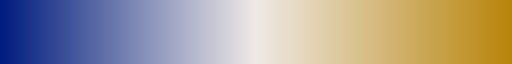

In [11]:
CTS_PAL = sns.blend_palette([
    TPAL[7],
    LIGHT,
    TPAL[1]
], as_cmap=True)
CTS_PAL

### Color Palette Tests

<Axes: >

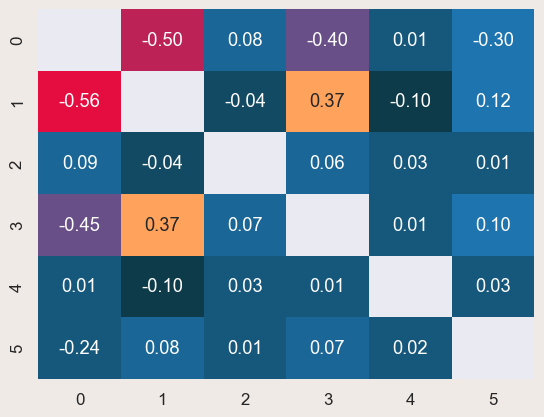

In [555]:

plt.figure(facecolor=LIGHT)
corr_m, corr_std, corr = label_correlations(train_Y)
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-0.6, vmax=0.4, cmap=CONPAL, cbar=False)

<Axes: >

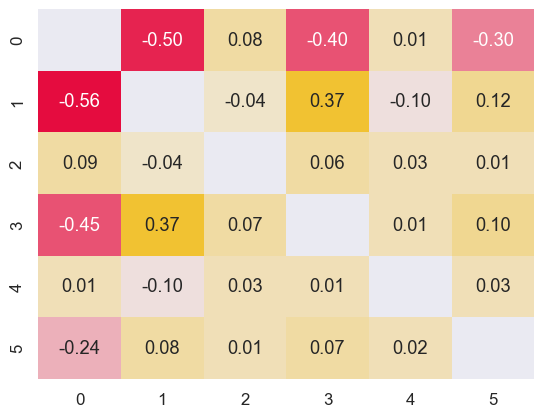

In [459]:

corr_m, corr_std, corr = label_correlations(train_Y)
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-0.6, vmax=0.4, cmap=DIVPAL, cbar=False)

## Data processing

In [13]:
angelina = os.path.join(DATASETS, "angelina.npz")
dsbi = os.path.join(DATASETS, "dsbi.npz")

data = np.load(angelina)
ood = np.load(dsbi)
print(data['train_x'].shape)
print(ood['test_x'].shape)

(69267, 40, 30, 3)
(45627, 40, 30, 3)


In [14]:
train_X = data["train_x"] / 255.
train_Y = data["train_y"]

val_X = data["val_x"] / 255.
val_Y = data["val_y"]

test_X = data["test_x"] / 255.
test_Y = data["test_y"]

N, p = train_Y.shape

In [15]:
train_Y_cat = ml_to_mc(train_Y)
val_Y_cat = ml_to_mc(val_Y)
test_Y_cat = ml_to_mc(test_Y)
test_Y_str = bin_to_string(test_Y)

C = train_Y_cat.shape[1]

In [16]:
ood_X = ood['test_x'] / 255.
ood_Y = ood['test_y']
ood_Y_cat = ml_to_mc(ood_Y)
ood_Y_str = bin_to_string(ood_Y)

In [17]:
del data, ood

## Scratch Calculations

In [516]:
a = [
    0.0011,
0.0007,
0.0013,
0.0016,
0.0027,
0.0017,
0.0022,
0.0007,
]

np.mean(a), np.std(a)

(0.0015, 0.0006576473218982953)

lr & b1 & b2  
Thresholds: 0.0015 & 0.9 & 0.995
0.0011 & 0.874 & 0.9982 --- low & low & high  
0.0007 & 0.870 & 0.9999 --- low & low & high  
0.0013 & 0.910 & 0.9958 --- low & mid & mid  
0.0016 & 0.950 & 0.9900 --- high & high & low  
0.0027 & 0.850 & 0.9983 --- high & low & high  
0.0017 & 0.950 & 0.9950 --- high & high & mid  
0.0022 & 0.850 & 0.9953 --- high & low & mid  
0.0007 & 0.850 & 0.9999 --- low & low & high  

Filt & KS & Dense & Pad
16-64 & 2-5 & 25-150 & T/F

64 & 3 & 46  & False --- H & L & L & L  
24 & 5 & 115 & True  --- L & H & H & H  
49 & 2 & 137 & True  --- H & L & H & H  
64 & 5 & 150 & False --- H & H & H & L  
41 & 3 & 65  & False --- H & L & L & L  
63 & 3 & 150 & False --- H & L & H & L  
16 & 3 & 150 & False --- L & L & H & L  
34 & 5 & 98  & True  --- L & H & H & H  

## Model evaluation

In [12]:
param_space = {
    'lr': (0.0001, 0.01),
    'beta_1': (0.85, 0.95),
    'beta_2': (0.99, 0.9999),
    'l2': (0.0005, 0.02),
    'filters': (16, 64),
    'kernel_sz': (2,5),
    'dense_sz': (25, 150),
    'activs': (0, 2),
    'padding': (0, 1),
    'grey': (0, 1),
    'sqr': (0, 1)
}

lr = 'Learning rate'
b1 = 'Beta1'
b2 = 'Beta2'
l2 = 'L2 penalty'
nf = 'Num filters'
ks = 'Kernel size'
ds = 'Dense layer size'
af = 'Activation function'
pa = 'Padding'
gs = 'Grey scaling'
si = 'Square input'

param_names = [
    lr, b1, b2, l2, nf, ks, ds, af, pa, gs, si
]


activations = {
    0: F.relu,
    1: F.tanh,
    2: F.leaky_relu
}
relu = "Relu"
lrelu = "Leaky relu"
tanh = "Tanh"
activ_names = [relu, tanh, lrelu]

categorical_params = [
    'kernel_sz', 'activs', 'padding', 'grey', 'sqr'
]

In [13]:
DEV = 'cpu'

NUM_CLASSES = 64
NUM_LABELS = 6

In [14]:
from matplotlib.patches import Patch, PathPatch, Rectangle, Shadow
from matplotlib.lines import Line2D
display(PAL)
display(CPAL)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

### Model loading

In [18]:
base_ml_model = ModelWrapper(dev=DEV)
base_ml_model.load(os.path.join(MODEL_PATH, 'base_ml_model_v2'))

base_mc_model = ModelWrapper(dev=DEV)
base_mc_model.load(os.path.join(MODEL_PATH, 'base_mc_model_v2'))

In [19]:
lb_ml_model = ModelWrapper(dev=DEV)
lb_ml_model.load(os.path.join(MODEL_PATH, 'lb_ml_model'))

lb_mc_model = ModelWrapper(dev=DEV)
lb_mc_model.load(os.path.join(MODEL_PATH, 'lb_mc_model'))

In [20]:
cb_ml_model = ModelWrapper(dev=DEV)
cb_ml_model.load(os.path.join(MODEL_PATH, 'cb_ml_model'))

cb_mc_model = ModelWrapper(dev=DEV)
cb_mc_model.load(os.path.join(MODEL_PATH, 'cb_mc_model'))

In [ ]:
ab_ml_model = ModelWrapper(dev=DEV)
ab_ml_model.load(os.path.join(MODEL_PATH, 'ab_ml_model'))

ab_mc_model = ModelWrapper(dev=DEV)
ab_mc_model.load(os.path.join(MODEL_PATH, 'ab_mc_model'))

RecursionError: maximum recursion depth exceeded

In [ ]:
# Model lists and model name lists
models = [base_mc_model, base_ml_model,
          cb_mc_model, cb_ml_model,
          lb_mc_model, lb_ml_model,
          ab_mc_model, ab_ml_model
        ]
model_names = ['Base MC', 'Base ML',
               'CB MC', 'CB ML',
               'LB MC', 'LB ML',
               'AB MC', 'AB ML'
            ]


base_ml_model.param_dict

{'in_size': [32, 32, 3],
 'filts': 24,
 'kerns': 5,
 'pad': 1,
 'out_size': 6,
 'activ': 'tanh',
 'dense_sz': 115,
 'beta_2': 0.9999,
 'beta_1': 0.8702337788234192,
 'l2': 0.0005,
 'lr': 0.0006905246895851634,
 'grey_scaled': 0,
 'square_in': 1}

In [22]:
from torchsummary import summary
summary(base_ml_model.model, input_size=(40, 30, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 30, 30]           1,824
            Conv2d-2           [-1, 24, 28, 28]          14,424
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 12, 12]          28,848
            Conv2d-5           [-1, 48, 10, 10]          57,648
         MaxPool2d-6             [-1, 48, 5, 5]               0
            Linear-7                  [-1, 115]         138,115
            Linear-8                    [-1, 6]             696
Total params: 241,555
Trainable params: 241,555
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 0.92
Estimated Total Size (MB): 1.38
----------------------------------------------------------------


In [23]:
base_ml_model.model

ConvModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1200, out_features=115, bias=True)
  (fc2): Linear(in_features=115, out_features=6, bias=True)
)

#### ID Test Predictions

In [24]:
ml_test_loader = myDataLoader(test_X, test_Y, batch_sz=2048, dev=DEV)
mc_test_loader = myDataLoader(test_X, test_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': test_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    if i % 2 == 0:
        preds = model.predict(mc_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

KeyboardInterrupt: 

In [25]:
# predictions.to_csv(os.path.join(EVAL, 'all_cbr_test_predictions.csv'), index=False)
predictions = pd.read_csv(os.path.join(EVAL, 'all_cbr_test_predictions.csv'), dtype=str)

In [26]:
predictions.head()

true_label Base MC Base ML   CB MC   CB ML   LB MC   LB ML
0     010111  011111  010110  010111  010111  010111  010111
1     101000  101000  101000  101000  101000  101000  101000
2     100110  100110  100110  100110  100110  100110  100110
3     111000  111000  111000  111000  111000  111000  111000
4     111110  111110  111110  111110  111110  111110  111110

In [27]:
correct_predictions = predictions.apply(
    lambda row: row == row['true_label'],
    axis=1
).drop(columns='true_label')
correct_predictions.head()

Base MC  Base ML  CB MC  CB ML  LB MC  LB ML
0    False    False   True   True   True   True
1     True     True   True   True   True   True
2     True     True   True   True   True   True
3     True     True   True   True   True   True
4     True     True   True   True   True   True

In [28]:
all_correct = correct_predictions[correct_predictions.all(axis=1)].index
all_wrong = correct_predictions[~correct_predictions.any(axis=1)].index

In [29]:
print(f"{all_correct.shape[0]} samples correctly classified by ALL models.")
display(all_correct.tolist()[:5])

print(f"{all_wrong.shape[0]} samples correctly classified by NONE of the models.")
display(all_wrong.tolist()[:5])

8963 samples correctly classified by ALL models.


[1, 2, 3, 4, 5]

17 samples correctly classified by NONE of the models.


[622, 1841, 1926, 2145, 3066]

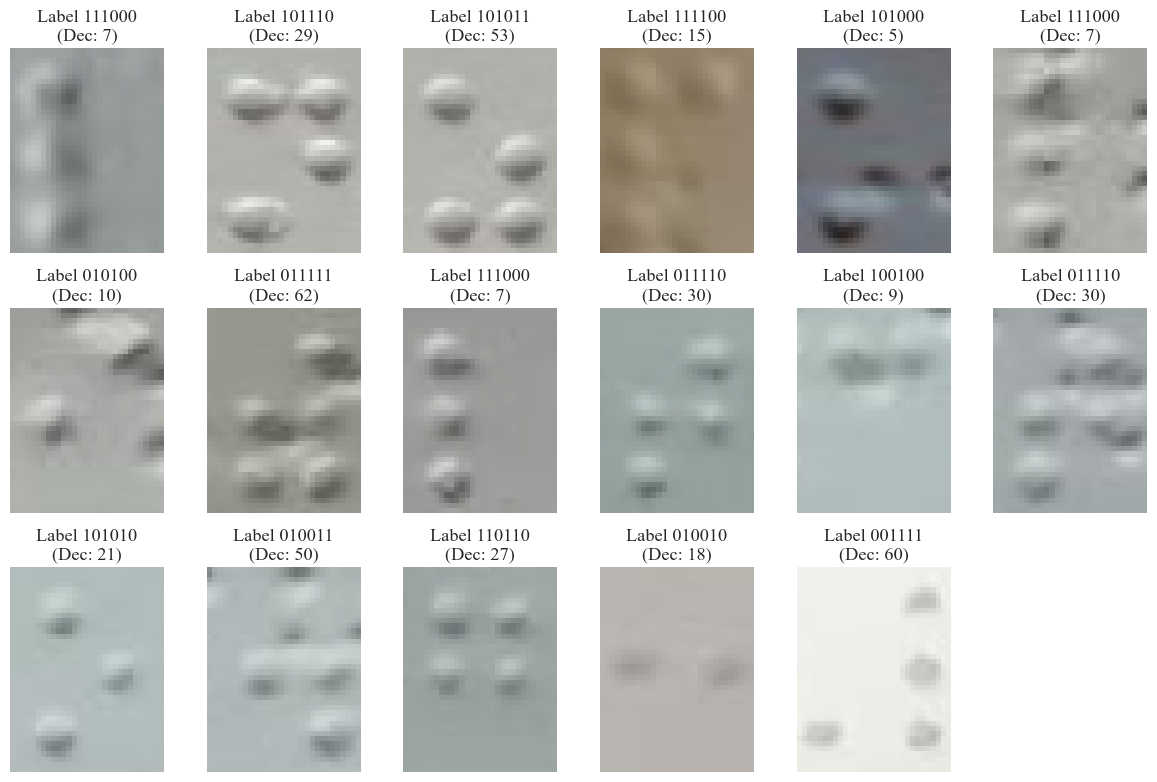

In [30]:
plt.figure(figsize=(12,8))

SET = all_wrong
for i in range(len(SET)):
    sample = (test_X[SET[i]]).astype(np.float32)
    plt.subplot(3,6, i+1)
    plt.axis("off")
    lbl = ''.join(test_Y[SET[i]].astype(str))
    num_lbl = np.argmax(test_Y_cat[SET[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl))
plt.tight_layout()

#### OOD Test Predictions

In [199]:
ml_ood_loader = myDataLoader(ood_X, ood_Y, batch_sz=2048, dev=DEV)
mc_ood_loader = myDataLoader(ood_X, ood_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': ood_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    print(f"Obtaining predictions for model {model_name}...")
    if i % 2 == 0:
        preds = model.predict(mc_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

predictions.to_csv(os.path.join(EVAL, 'all_cbr_ood_predictions.csv'), index=False)

Obtaining predictions for model Base MC...
Obtaining predictions for model Base ML...
Obtaining predictions for model CB MC...
Obtaining predictions for model CB ML...
Obtaining predictions for model LB MC...
Obtaining predictions for model LB ML...


In [31]:
# predictions.to_csv(os.path.join(EVAL, 'all_cbr_test_predictions.csv'), index=False)
predictions = pd.read_csv(os.path.join(EVAL, 'all_cbr_ood_predictions.csv'), dtype=str)

In [32]:
predictions.head()

true_label Base MC Base ML   CB MC   CB ML   LB MC   LB ML
0     010100  010100  010100  010100  010100  010100  010100
1     101000  101000  101000  101000  101000  101000  101000
2     001100  101100  001100  001100  001100  001100  001100
3     011000  011100  011000  011000  011000  011000  011000
4     010001  010001  010001  010001  010001  010000  010001

### Model Inspection

In [ ]:
def compute_max_saliency(model, sample_tensor):
    model.eval()
    sample_tensor.requires_grad_()
    scores = model(sample_tensor)
    score_max_idx = scores.argmax()
    score_max = scores[0, score_max_idx]

    score_max.backward()
    max_saliency, _ = torch.max(sample_tensor.grad.data.abs(),dim=3)
    
    return max_saliency[0]

def compute_target_saliency(model, sample_tensor, target):
    model.eval()
    sample_tensor.requires_grad_()
    scores = model(sample_tensor)
    score_target = scores[0, target]

    score_target.backward()
    target_saliency, _ = torch.max(sample_tensor.grad.data.abs(),dim=3)
    
    return target_saliency[0]

In [125]:
def investigate_class_saliencies(model, sample_tensor, true_class):
    fig, axes = plt.subplots(4, 16, figsize=(30,10))

    saliencies = []
    for i in range(NUM_CLASSES):
        ax = axes[i // 16, i % 16]
        target_saliency = compute_target_saliency(model, sample_tensor, i)
        saliencies.append(target_saliency)

        ax.imshow(target_saliency, cmap=plt.cm.hot)
        true_label_str = " (Target)" if i == true_class else ""
        fw = 'bold' if i == true_class else 'normal'
        ax.set_title(f"Class {i}{true_label_str}", fontweight=fw)
        ax.axis('off')
    
    mean_saliency = np.mean(saliencies, axis=0)
    return fig, mean_saliency

In [127]:
def investigate_label_saliencies(model, sample_tensor, true_label):
    fig, axes = plt.subplots(3, 2, figsize=(7,15))

    saliencies = []
    for i in range(NUM_LABELS):
        ax = axes[i % 3, i // 3]
        target_saliency = compute_target_saliency(model, sample_tensor, i)
        saliencies.append(target_saliency)

        ax.imshow(target_saliency, cmap=plt.cm.hot)
        fw = 'bold' if int(true_label[i]) == 1 else 'normal'
        ax.set_title(f"Label {i+1} ({true_label[i]})", fontweight=fw)
        ax.axis('off')
    
    mean_saliency = np.mean(saliencies, axis=0)
    return fig, mean_saliency

In [126]:
gs, bs = 1, 622

good_sample = test_X[gs]
good_sample_tensor = torch.Tensor(np.array([good_sample]))
good_sample_class = test_Y_cat[gs].argmax()
good_sample_ml = test_Y[gs]

bad_sample = test_X[bs]
bad_sample_tensor = torch.Tensor(np.array([bad_sample]))
bad_sample_class = test_Y_cat[bs].argmax()
bad_sample_ml = test_Y[bs]

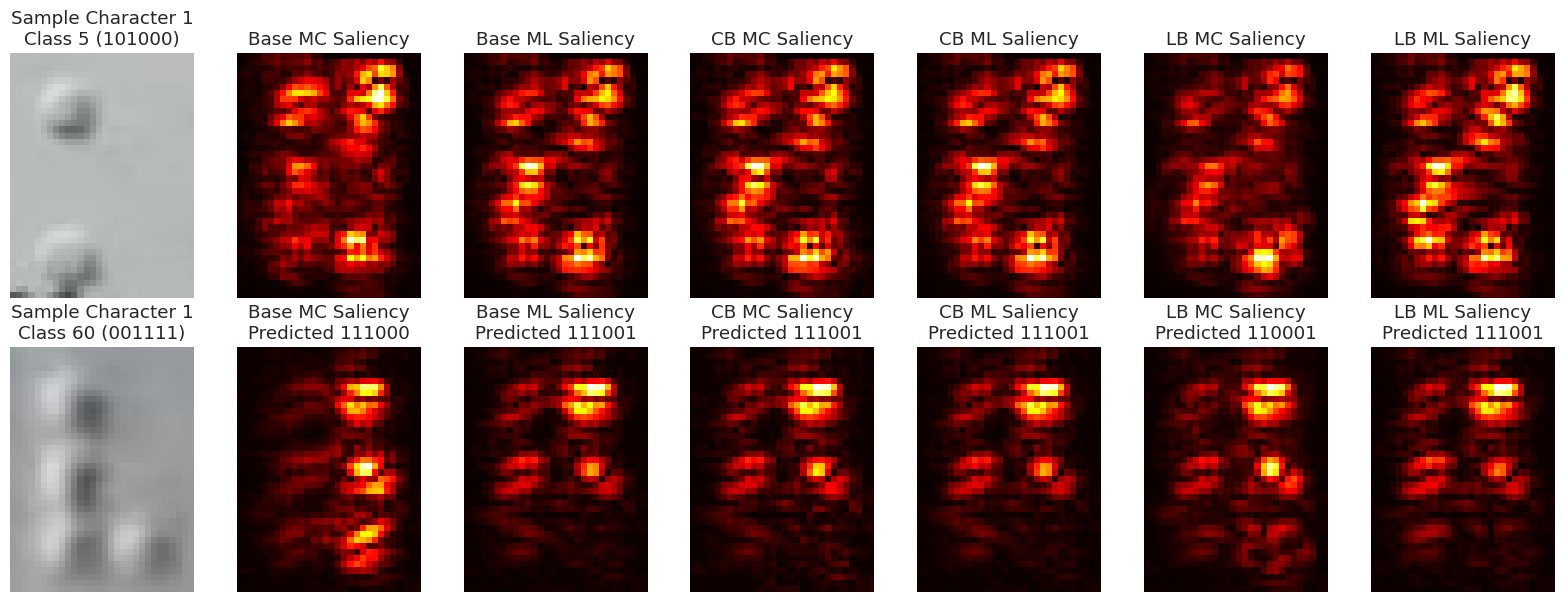

In [148]:
m_fig, m_axes = plt.subplots(2, 7, figsize=(20, 7))
plt.ioff()

m_axes[0, 0].imshow(good_sample)
m_axes[0, 0].set_title(f"Sample Character 1\nClass {good_sample_class} ({bin_to_string(good_sample_ml.astype(str).tolist())})")
m_axes[0, 0].axis('off')

m_axes[1, 0].imshow(bad_sample)
m_axes[1, 0].set_title(f"Sample Character 1\nClass {bad_sample_class} ({bin_to_string(bad_sample_ml.astype(str).tolist())})")
m_axes[1, 0].axis('off')

for m, (model, model_name) in enumerate(zip(models, model_names)):
    model_bs_pred_ml = predictions.loc[bs, model_name]
    model_bs_pred = bin_to_num(np.array(list(model_bs_pred_ml), dtype=int))

    if m % 2 == 0: # MC
        gfig, gsaliency = investigate_class_saliencies(model.model, good_sample_tensor, good_sample_class)
        bfig, bsaliency = investigate_class_saliencies(model.model, bad_sample_tensor, bad_sample_class)

    else: # ML
        gfig, gsaliency = investigate_label_saliencies(model.model, good_sample_tensor, good_sample_ml)
        bfig, bsaliency = investigate_label_saliencies(model.model, bad_sample_tensor, bad_sample_ml)

    gfig.savefig(os.path.join(PLOTS, f"saliencies_per_target_{model_name.lower().replace(' ', '_')}_good_sample.png"), bbox_inches='tight')
    bfig.savefig(os.path.join(PLOTS, f"saliencies_per_target_{model_name.lower().replace(' ', '_')}_bad_sample.png"), bbox_inches='tight')
    plt.close(gfig)
    plt.close(bfig)

    m_axes[0, m+1].imshow(gsaliency, cmap=plt.cm.hot)
    m_axes[0, m+1].set_title(f"{model_name} Saliency")
    m_axes[0, m+1].axis('off')

    m_axes[1, m+1].imshow(bsaliency, cmap=plt.cm.hot)
    m_axes[1, m+1].set_title(f"{model_name} Saliency\nPredicted {model_bs_pred_ml}")
    m_axes[1, m+1].axis('off')
m_fig.show()


In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as BK


In [ ]:
saliency_idx = [1, 111, 608, 5, 1129, 59, 70]
saliency_samples = []
for i, idx in enumerate(saliency_idx):
    sample = os_test_X[idx]
    if i == 3:
        sample = np.flip(sample, 1)
    saliency_samples.append(sample)
saliency_samples = np.array(saliency_samples)

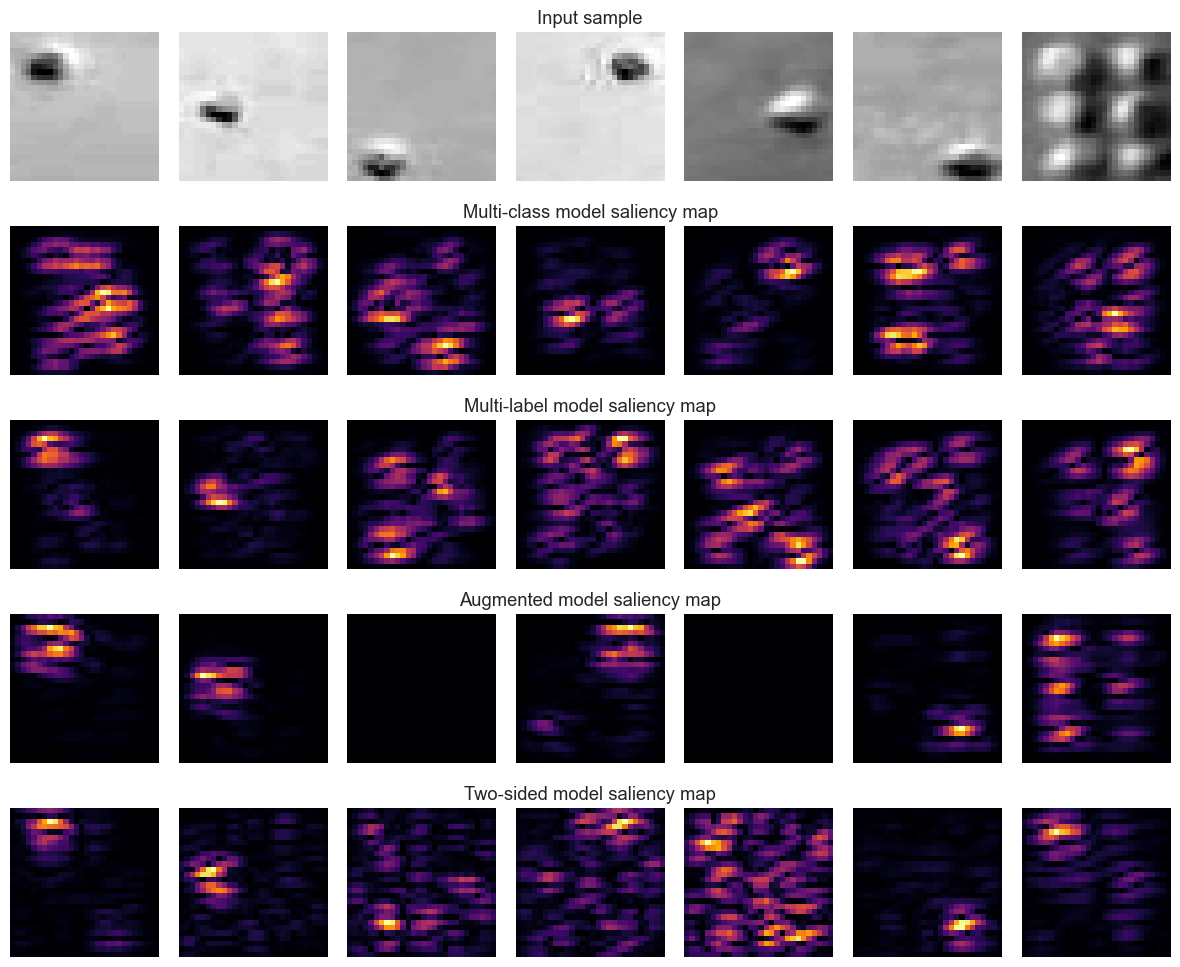

In [ ]:
def compute_saliency(model, img_array, full=False):
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        top_prediction = tf.argmax(predictions[0])
        output = predictions[:, top_prediction]

    if full:
        gradient = tape.gradient(predictions, img_array)
    else:
        gradient = tape.gradient(output, img_array)
    saliency = tf.abs(gradient[0])
    return saliency 

saliencies = []
for i, img in enumerate(saliency_samples):
    img_array = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    sal_i = []
    for m, model in enumerate([mc_model, ml_model, aug_model, ts_model]):
        sal_i.append(compute_saliency(model, img_array, m > 0 and i == 6))
    saliencies.append(sal_i)

fig, axes = plt.subplots(5, 7, figsize=(12,10))
for i in range(7):
    axes[0,i].imshow(saliency_samples[i])
    axes[0,i].axis("off")
    for m in range(4):
        axes[m+1,i].imshow(saliencies[i][m], cmap='inferno')
        axes[m+1,i].axis('off')
        
axes[0,3].set_title("Input sample")
axes[1,3].set_title("Multi-class model saliency map")
axes[2,3].set_title("Multi-label model saliency map")
axes[3,3].set_title("Augmented model saliency map")
axes[4,3].set_title("Two-sided model saliency map")

plt.tight_layout()


## F-Race Hyperparameters Inspection

### Load Logs

In [15]:
BASE_TIME = "20240910_055505"
CB_TIME = "20241008_124953"
LB_TIME = "20240926_142401"
AB_TIME = "20250616_103525"

# names
BASE = 'No Resampling'
CB = 'Class Resampled'
LB = 'Label Resampled'
AB = 'Adaptive Resampled'
MC = 'Multiclass'
ML = 'Multilabel'

MODEL_COL = 'Model'
TRAIN_COL = 'Resampling Scenario'
FOLD_COL = 'Fold'
CONFIG_COL = 'Configuration ID'

timestamps = [BASE_TIME, CB_TIME, LB_TIME, AB_TIME]
prefixes = ["base", "cb", "lb", "ab"]
sets = ['historic', 'elite']

resamplings = [BASE, CB, LB, AB]
model_types = [MC, ML]
model_logs = [MC_LOGS, ML_LOGS]

In [16]:
abbreviations = {
    BASE: "NR",
    CB: "CR",
    LB: "LR",
    AB: "AR",
    MC: "MC",
    ML: "ML",
    # ID: "ID",
    # DSBI: "OOD",
    # B37: "B37",
    # BCD: "BCD",
    # ABC: "ABC",
    # BRIGHT: "BRT",
    # NOISE: "NSE",
    # ROT: "ROT",
    # BLUR: "BLR",
    # cErr: "CErr",
    # lErr: "LErr",
    # errDist: "ErrD",
    # cRec: "CRec",
    # cPrec: "CPrec",
    # cF1: "CF$_1$",
    # lRec: "LRec",
    # lPrec: "LPrec",
    # lF1: "LF$_1$",
}

In [17]:
frace_results_df = pd.DataFrame(
    columns=[
        TRAIN_COL, MODEL_COL, CONFIG_COL, FOLD_COL, 'Validation Loss', 'Best Configuration'
    ] + param_names
)    

for r, (prefix, timestamp, resample) in enumerate(zip(prefixes, timestamps, resamplings)):
    for m, (log_path, model) in enumerate(zip(model_logs, model_types)):
        with open(os.path.join(log_path, f"{prefix}_{timestamp}_elite_set.json"), 'r') as f:
            elite_result = json.load(f)
        with open(os.path.join(log_path, f"{prefix}_{timestamp}_historic_set.json"), 'r') as f:
            history = json.load(f)

        configs, losses, _, _ = history.values()
        highest = int(elite_result['final_ranks'][0])
        
        for c, config in configs.items():
            for f, loss in enumerate(losses[c]):
                frace_results_df.loc[frace_results_df.shape[0]] = [
                    resample,
                    model,
                    int(c),
                    f,
                    loss,
                    highest == int(c)
                ] + config
    #     break
    # break

In [18]:
frace_results_df.head()

Resampling Scenario       Model  Configuration ID  Fold  Validation Loss  \
0       No Resampling  Multiclass                 0     0         3.447217   
1       No Resampling  Multiclass                 0     1         3.422917   
2       No Resampling  Multiclass                 0     2         3.423376   
3       No Resampling  Multiclass                 0     3         3.411522   
4       No Resampling  Multiclass                 0     4         3.444831   

   Best Configuration  Learning rate     Beta1     Beta2  L2 penalty  \
0               False       0.007985  0.887414  0.995392    0.009277   
1               False       0.007985  0.887414  0.995392    0.009277   
2               False       0.007985  0.887414  0.995392    0.009277   
3               False       0.007985  0.887414  0.995392    0.009277   
4               False       0.007985  0.887414  0.995392    0.009277   

   Num filters  Kernel size  Dense layer size  Activation function  Padding  \
0           25            4               106                    0        1   
1           25            4               106                    0        1   
2           25            4               106                    0        1   
3           25            4               106                    0        1   
4           25            4               106                    0        1   

   Grey scaling  Square input  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0

In [19]:
frace_results_df[frace_results_df['Best Configuration']].head()

Resampling Scenario       Model  Configuration ID  Fold  Validation Loss  \
200       No Resampling  Multiclass                40     0         0.170713   
201       No Resampling  Multiclass                40     1         0.145605   
202       No Resampling  Multiclass                40     2         0.158638   
203       No Resampling  Multiclass                40     3         0.164964   
204       No Resampling  Multiclass                40     4         0.135784   

     Best Configuration  Learning rate     Beta1     Beta2  L2 penalty  \
200                True       0.001133  0.874297  0.998162      0.0005   
201                True       0.001133  0.874297  0.998162      0.0005   
202                True       0.001133  0.874297  0.998162      0.0005   
203                True       0.001133  0.874297  0.998162      0.0005   
204                True       0.001133  0.874297  0.998162      0.0005   

     Num filters  Kernel size  Dense layer size  Activation function  Padding  \
200           64            3                46                    0        0   
201           64            3                46                    0        0   
202           64            3                46                    0        0   
203           64            3                46                    0        0   
204           64            3                46                    0        0   

     Grey scaling  Square input  
200             0             0  
201             0             0  
202             0             0  
203             0             0  
204             0             0

In [20]:
frace_results_df_nonoutlier = frace_results_df.copy()
frace_results_df_nonoutlier.loc[frace_results_df['Validation Loss'] > 30, 'Validation Loss'] = pd.NA

frace_aggregate_df = frace_results_df_nonoutlier.groupby(
    [TRAIN_COL, MODEL_COL, CONFIG_COL] + param_names
).agg(
    {
        'Validation Loss': np.nanmean,
        'Best Configuration': 'max'
    }
).reset_index()
frace_aggregate_df.rename(columns={
    'Validation Loss': 'Mean Validation Loss'
}, inplace=True)
frace_aggregate_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_24212\2786874428.py:6: FutureWarning: The provided callable <function nanmean at 0x00000239E1193240> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(


Resampling Scenario       Model  Configuration ID  Learning rate     Beta1  \
0  Adaptive Resampled  Multiclass                 0       0.002799  0.872994   
1  Adaptive Resampled  Multiclass                 1       0.006618  0.903780   
2  Adaptive Resampled  Multiclass                 2       0.008847  0.886139   
3  Adaptive Resampled  Multiclass                 3       0.000698  0.943731   
4  Adaptive Resampled  Multiclass                 4       0.002374  0.888583   

      Beta2  L2 penalty  Num filters  Kernel size  Dense layer size  \
0  0.995875    0.010593           31            2               130   
1  0.991821    0.005815           48            5                27   
2  0.999438    0.018049           62            4               111   
3  0.992976    0.003482           18            3                74   
4  0.990607    0.002717           24            3                94   

   Activation function  Padding  Grey scaling  Square input  \
0                    2        1             1             0   
1                    0        0             0             1   
2                    1        0             0             1   
3                    1        1             1             0   
4                    1        0             0             1   

   Mean Validation Loss  Best Configuration  
0              3.954759               False  
1              2.583850               False  
2              3.954846               False  
3              0.328711               False  
4              0.242760               False

In [21]:
frace_aggregate_df[af] = frace_aggregate_df[af].apply(
    lambda a: activations[a].__name__.replace('_', ' ').capitalize()
    )
frace_aggregate_df[af] = pd.Categorical(
    frace_aggregate_df[af], categories=activ_names, ordered=True
)
frace_aggregate_df[pa] = frace_aggregate_df[pa].astype(bool)
frace_aggregate_df[gs] = frace_aggregate_df[gs].astype(bool)
frace_aggregate_df[si] = frace_aggregate_df[si].astype(bool)

In [22]:
frace_aggregate_df[frace_aggregate_df['Best Configuration']].head()

Resampling Scenario       Model  Configuration ID  Learning rate  \
57   Adaptive Resampled  Multiclass                57       0.002247   
186  Adaptive Resampled  Multilabel                90       0.000664   
266     Class Resampled  Multiclass                74       0.001278   
349     Class Resampled  Multilabel                61       0.001623   
448     Label Resampled  Multiclass                64       0.002673   

        Beta1     Beta2  L2 penalty  Num filters  Kernel size  \
57   0.850000  0.995300      0.0005           16            3   
186  0.850000  0.999900      0.0005           34            5   
266  0.910123  0.995761      0.0005           49            2   
349  0.950000  0.990000      0.0005           64            5   
448  0.850000  0.998252      0.0005           41            3   

     Dense layer size Activation function  Padding  Grey scaling  \
57                150                Tanh    False         False   
186                98          Leaky relu     True         False   
266               137                Tanh     True         False   
349               150          Leaky relu    False          True   
448                65                Relu    False         False   

     Square input  Mean Validation Loss  Best Configuration  
57          False              0.195131                True  
186         False              0.008917                True  
266         False              0.467616                True  
349         False              0.012849                True  
448         False              0.124340                True

In [23]:
frace_aggregate_df[
    (frace_aggregate_df[TRAIN_COL] == AB) &
    (frace_aggregate_df[MODEL_COL] == MC)
    ].sort_values([
    'Activation function'
], ascending=False).head(10)

Resampling Scenario       Model  Configuration ID  Learning rate     Beta1  \
0   Adaptive Resampled  Multiclass                 0       0.002799  0.872994   
52  Adaptive Resampled  Multiclass                52       0.000100  0.882099   
38  Adaptive Resampled  Multiclass                38       0.003120  0.850000   
39  Adaptive Resampled  Multiclass                39       0.000100  0.853667   
40  Adaptive Resampled  Multiclass                40       0.000100  0.866688   
41  Adaptive Resampled  Multiclass                41       0.000100  0.850000   
42  Adaptive Resampled  Multiclass                42       0.001491  0.850000   
43  Adaptive Resampled  Multiclass                43       0.000100  0.850000   
44  Adaptive Resampled  Multiclass                44       0.000765  0.906286   
45  Adaptive Resampled  Multiclass                45       0.008575  0.938142   

       Beta2  L2 penalty  Num filters  Kernel size  Dense layer size  \
0   0.995875    0.010593           31            2               130   
52  0.999900    0.000500           55            4               150   
38  0.999900    0.000500           64            2                25   
39  0.999900    0.018434           64            2               150   
40  0.999900    0.005062           49            2               150   
41  0.999900    0.015810           64            3                25   
42  0.999894    0.006144           64            2                75   
43  0.999900    0.000500           64            2               150   
44  0.996321    0.000500           64            2                53   
45  0.999900    0.014207           17            2               150   

   Activation function  Padding  Grey scaling  Square input  \
0           Leaky relu     True          True         False   
52          Leaky relu    False         False         False   
38          Leaky relu    False         False         False   
39          Leaky relu    False         False         False   
40          Leaky relu     True         False         False   
41          Leaky relu     True         False         False   
42          Leaky relu    False         False         False   
43          Leaky relu    False         False         False   
44          Leaky relu    False         False         False   
45          Leaky relu    False         False         False   

    Mean Validation Loss  Best Configuration  
0               3.954759               False  
52              0.387724               False  
38              0.235196               False  
39              0.904479               False  
40              0.546854               False  
41              1.318012               False  
42              3.244891               False  
43              0.413685               False  
44              0.257296               False  
45              3.955746               False

In [24]:
frace_aggregate_df[frace_aggregate_df['Best Configuration']]

Resampling Scenario       Model  Configuration ID  Learning rate  \
57   Adaptive Resampled  Multiclass                57       0.002247   
186  Adaptive Resampled  Multilabel                90       0.000664   
266     Class Resampled  Multiclass                74       0.001278   
349     Class Resampled  Multilabel                61       0.001623   
448     Label Resampled  Multiclass                64       0.002673   
534     Label Resampled  Multilabel                54       0.001686   
616       No Resampling  Multiclass                40       0.001133   
726       No Resampling  Multilabel                54       0.000691   

        Beta1     Beta2  L2 penalty  Num filters  Kernel size  \
57   0.850000  0.995300      0.0005           16            3   
186  0.850000  0.999900      0.0005           34            5   
266  0.910123  0.995761      0.0005           49            2   
349  0.950000  0.990000      0.0005           64            5   
448  0.850000  0.998252      0.0005           41            3   
534  0.950000  0.995028      0.0005           63            3   
616  0.874297  0.998162      0.0005           64            3   
726  0.870234  0.999900      0.0005           24            5   

     Dense layer size Activation function  Padding  Grey scaling  \
57                150                Tanh    False         False   
186                98          Leaky relu     True         False   
266               137                Tanh     True         False   
349               150          Leaky relu    False          True   
448                65                Relu    False         False   
534               150                Relu    False         False   
616                46                Relu    False         False   
726               115                Tanh     True         False   

     Square input  Mean Validation Loss  Best Configuration  
57          False              0.195131                True  
186         False              0.008917                True  
266         False              0.467616                True  
349         False              0.012849                True  
448         False              0.124340                True  
534         False              0.012522                True  
616         False              0.155141                True  
726          True              0.018672                True

### Visualise Parameters

In [25]:
training_color = {
    BASE: 0,
    CB: 1,
    LB: 2,
    AB: 3
}

model_style = {
    MC: '-',
    ML: '--'
}

model_markers = {
    MC: 'o',
    ML: 'X'
}

# hatches = ['', '\\\\//', '..']
model_hatches = {
    MC: '',
    ML: '\\\\//'
}
model_sizes = {
    MC: 80,
    ML: 90
}

legend_pos = {
    MC: ('upper left', (0., 0.)),
    ML: ('lower right', (1., 1.)),
}

In [26]:
param_label = {
    'lr': lambda x: round(x, 4),
    'beta_1': lambda x: round(x, 3),
    'beta_2': lambda x: round(x, 4),
    'l2': lambda x: round(x, 6),
    'filters': lambda x: int(x),
    'kernel_sz': lambda x: int(x),
    'dense_sz': lambda x: int(x),
    'activs': lambda x: x,
    'padding': lambda x: x,
    'grey': lambda x: x,
    'sqr': lambda x: x
}

<Axes: xlabel='Kernel Size', ylabel='Mean Validation Loss'>

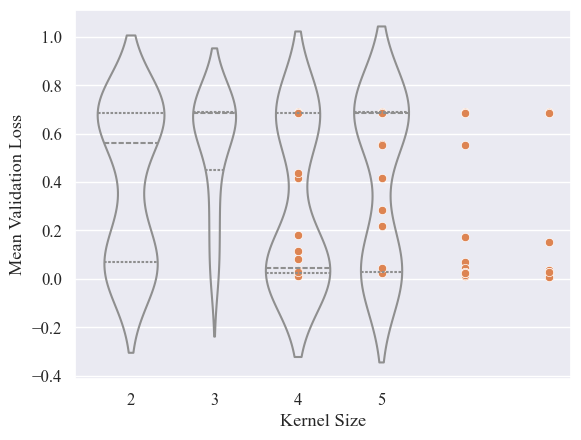

In [31]:
sns.violinplot(
    data=frace_aggregate_df[
        (frace_aggregate_df[TRAIN_COL] == resample) &
        (frace_aggregate_df[MODEL_COL] == model)
        ],
    x='Kernel Size',
    y='Mean Validation Loss',
    fill=False,
    edgecolor=GREY,
    # linestyle='--',
    inner='quarts',
    # alpha=0.7,
    density_norm='count'
)
sns.scatterplot(
    data=frace_aggregate_df[
        (frace_aggregate_df[TRAIN_COL] == resample) &
        (frace_aggregate_df[MODEL_COL] == model)
        ],
    x='Kernel Size',
    y='Mean Validation Loss',
    # fill=False,
    # edgecolor=GREY,
    # # linestyle='--',
    # inner='quarts',
    # # alpha=0.7,
    # density_norm='count'
)

<Axes: xlabel='L2 Penalty', ylabel='Mean Validation Loss'>

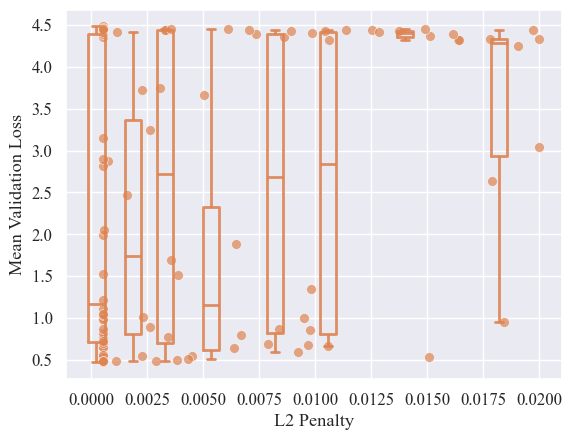

In [ ]:
param = list(param_space.keys())[3]
param_name = param_names[3]
    
data = frace_aggregate_df[
        (frace_aggregate_df[TRAIN_COL] == CB) &
        (frace_aggregate_df[MODEL_COL] == MC)
        ]
p_bin = f"{param_name} Binned"
bin_loc = f"Bin Center"
data[p_bin] = pd.qcut(data[param_name], q=12, duplicates='drop')
data[bin_loc] = data[p_bin].apply(lambda x: (x.left + x.right) / 2).astype(float)

sns.scatterplot(
    data=data,
    x=param_name if param != 'kernel_sz' else data[param_name] - 2,
    y='Mean Validation Loss',
    color=CPAL[1],
    marker=model_markers[MC],
    alpha=0.7,
    s=50,
    linewidth=0.5,
    # ax=ax
)
props = {
    'alpha': 0.9,
    'linestyle': '-'
}
sns.boxplot(data=data, x=bin_loc, y='Mean Validation Loss', zorder=3, fill=False, color=CPAL[1], native_scale=True,
            width=0.5,  linewidth=2., showfliers=False,
            gap=0.,
            flierprops=props,
            boxprops=props,
            medianprops=props,
            whiskerprops=props,
            capprops=props)

In [27]:
version = "v3"

In [28]:
import warnings

warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


Text(0.5, 0.98, 'Aggregated losses')

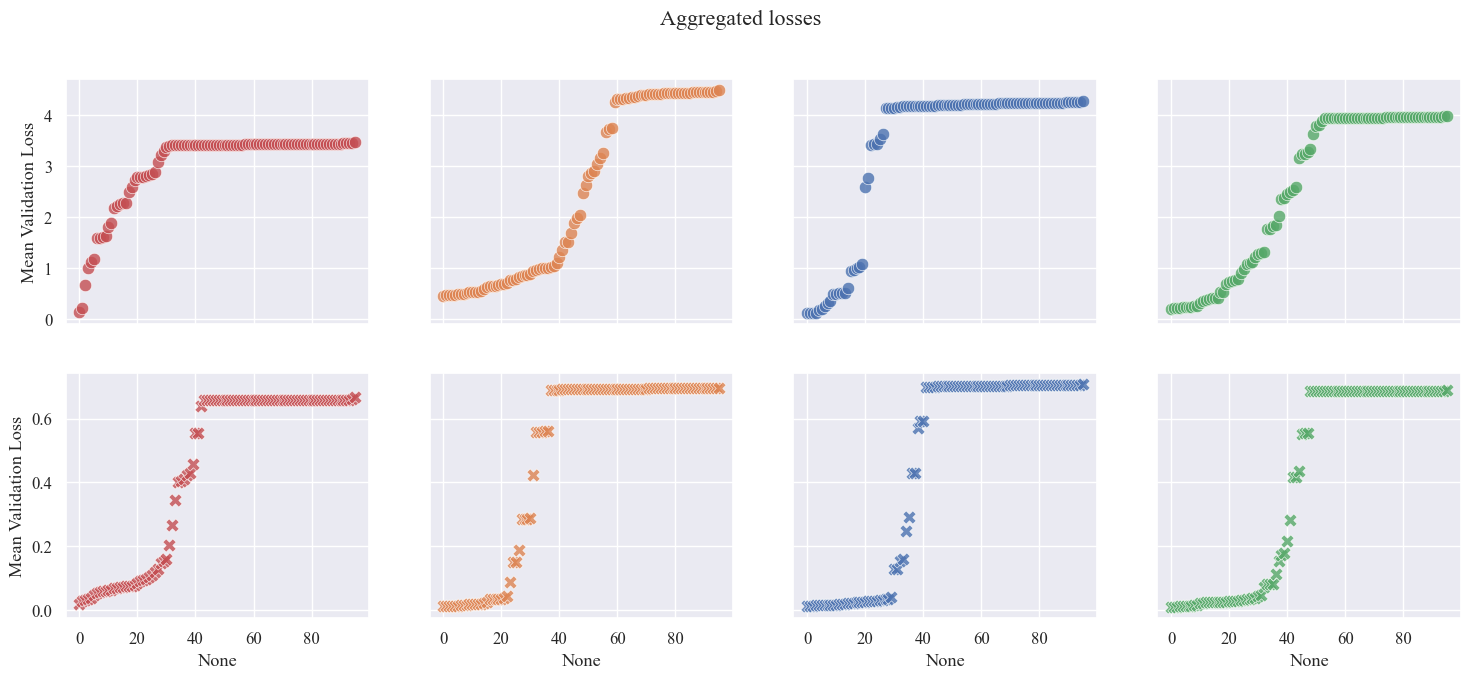

In [231]:

fig, axes = plt.subplots(
    2, 4, figsize=(18, 7), sharey='row', sharex='col'
)

for r, resample in enumerate(resamplings):
    for m, model in enumerate(model_types):
        ax = axes[m, r]
        data = frace_aggregate_df[
                (frace_aggregate_df[TRAIN_COL] == resample) &
                (frace_aggregate_df[MODEL_COL] == model)
                ].sort_values('Mean Validation Loss').reset_index()
        sns.scatterplot(
            data=data,
            x=data.index,
            y='Mean Validation Loss',
            color=CPAL[r],
            marker=model_markers[model],
            alpha=0.8,
            s=model_sizes[model],
            linewidth=0.5,
            ax=ax, zorder=2,
        )
plt.suptitle('Aggregated losses')

Text(0.5, 0.98, 'Per-fold losses')

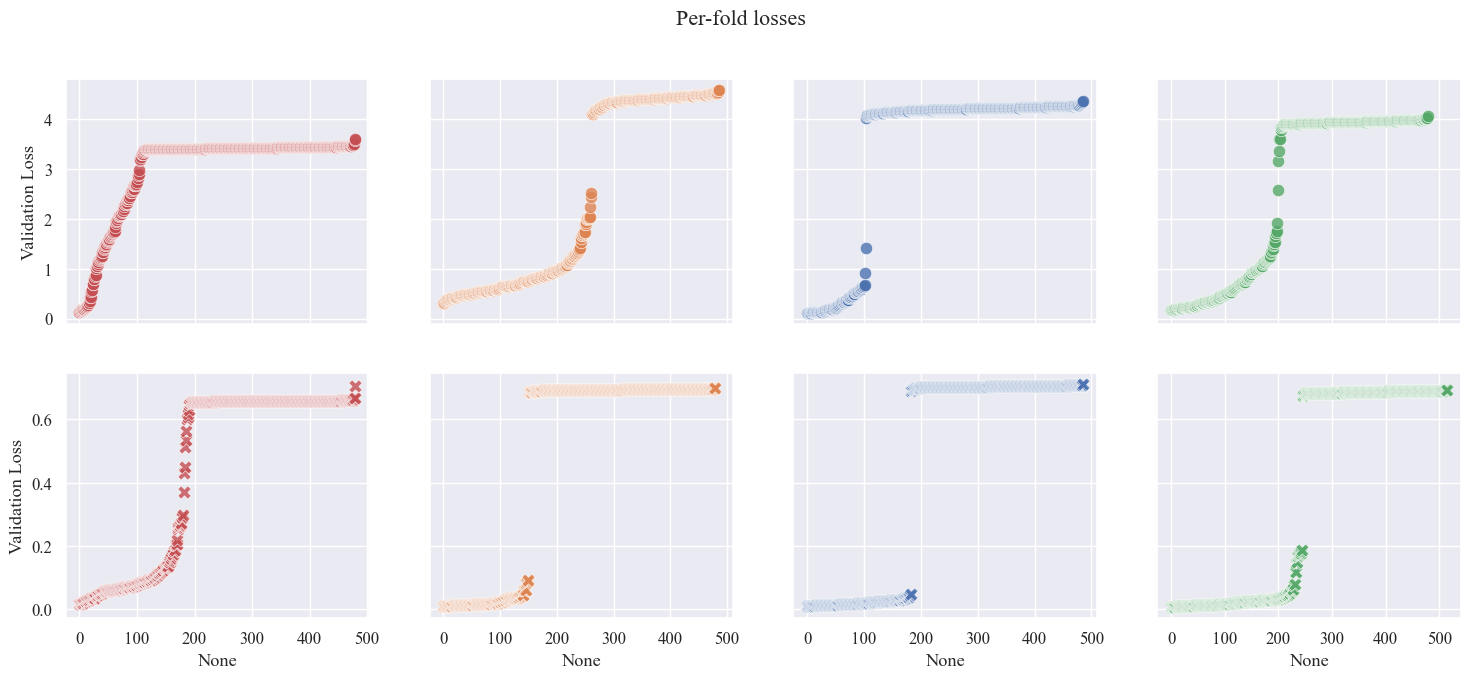

In [234]:

fig, axes = plt.subplots(
    2, 4, figsize=(18, 7), sharey='row', sharex='col'
)

for r, resample in enumerate(resamplings):
    for m, model in enumerate(model_types):
        ax = axes[m, r]
        data = frace_results_df_nonoutlier[
                (frace_results_df_nonoutlier[TRAIN_COL] == resample) &
                (frace_results_df_nonoutlier[MODEL_COL] == model)
                ].sort_values('Validation Loss').reset_index()
        sns.scatterplot(
            data=data,
            x=data.index,
            y='Validation Loss',
            color=CPAL[r],
            marker=model_markers[model],
            alpha=0.8,
            s=model_sizes[model],
            linewidth=0.5,
            ax=ax, zorder=2,
        )
plt.suptitle('Per-fold losses')

In [30]:
param_space.keys()

dict_keys(['lr', 'beta_1', 'beta_2', 'l2', 'filters', 'kernel_sz', 'dense_sz', 'activs', 'padding', 'grey', 'sqr'])

In [44]:
x_locators = {
    'lr': (ticker.MultipleLocator(0.005, 0), (-0.0015, 0.011)),
    'beta_1': (ticker.MultipleLocator(0.05, 0), (0.84, 0.96)),
    'beta_2': (ticker.MultipleLocator(0.005, 0), (0.9885, 1.001)),
    'l2': (ticker.MultipleLocator(0.01, 0), (-0.002, 0.022)),
    'filters': (ticker.MultipleLocator(20, 0), (10, 70)),
    'kernel_sz': (ticker.MultipleLocator(1, 0), (-0.9, 3.9)),
    'dense_sz': (ticker.MultipleLocator(50, 25), (15, 160)),
    # af: (ticker.MultipleLocator(0.15, 0), ()),
    # pa: (ticker.MultipleLocator(0.15, 0), ()),
    # gs: (ticker.MultipleLocator(0.15, 0), ()),
    # si: (ticker.MultipleLocator(0.15, 0), ()),
}

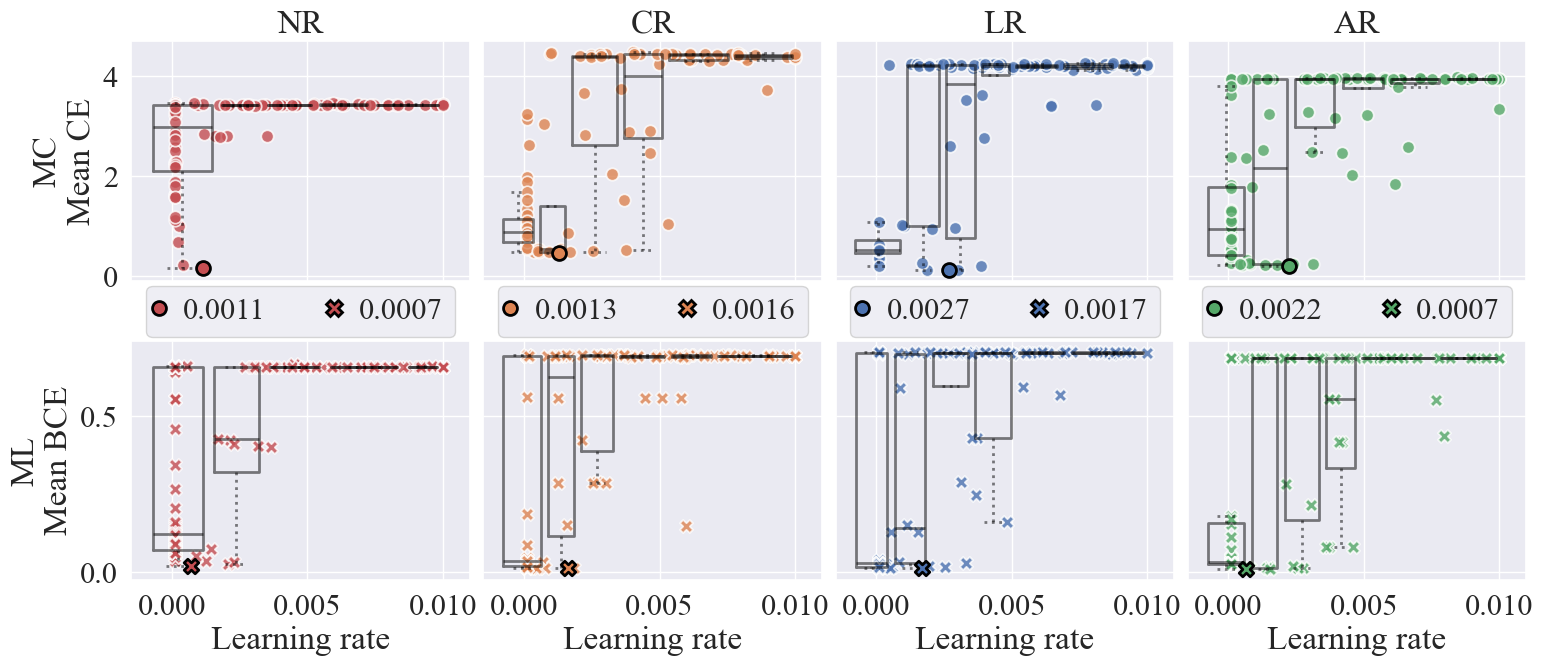

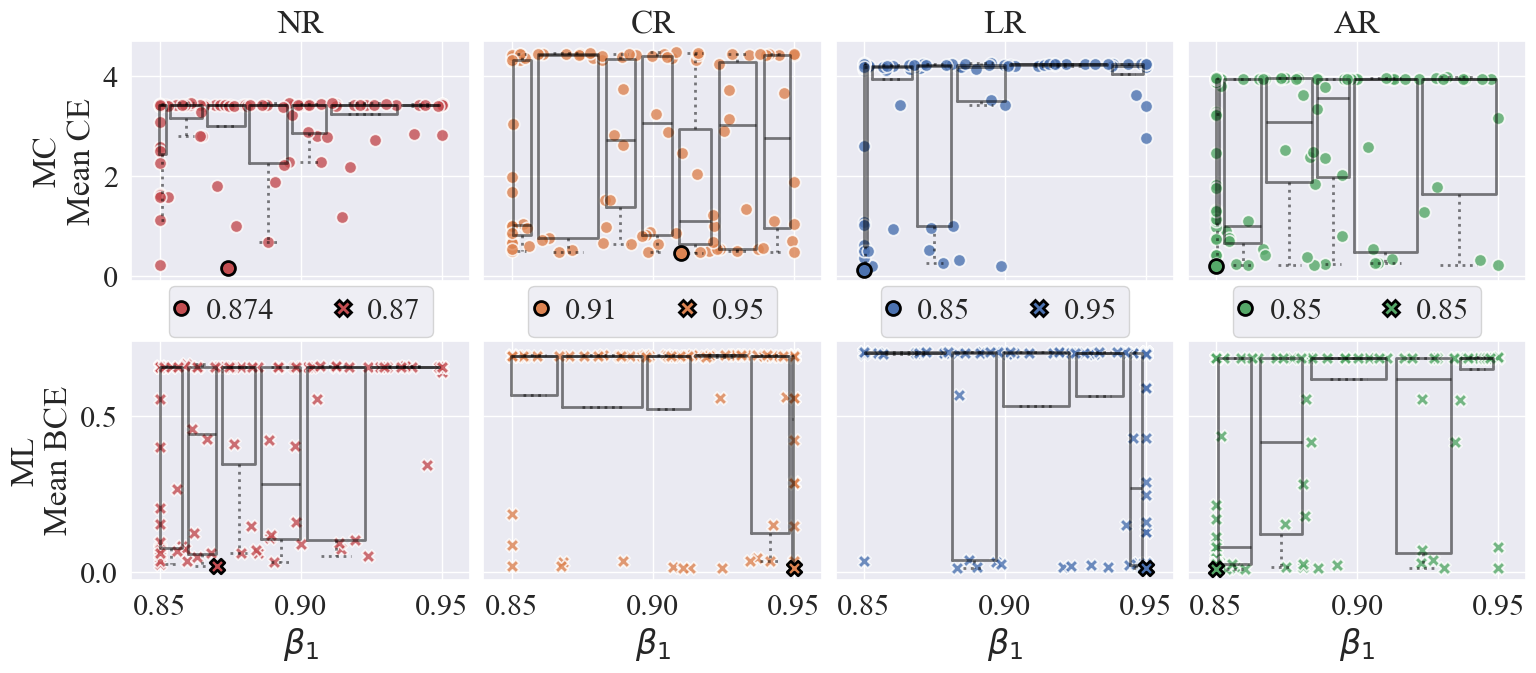

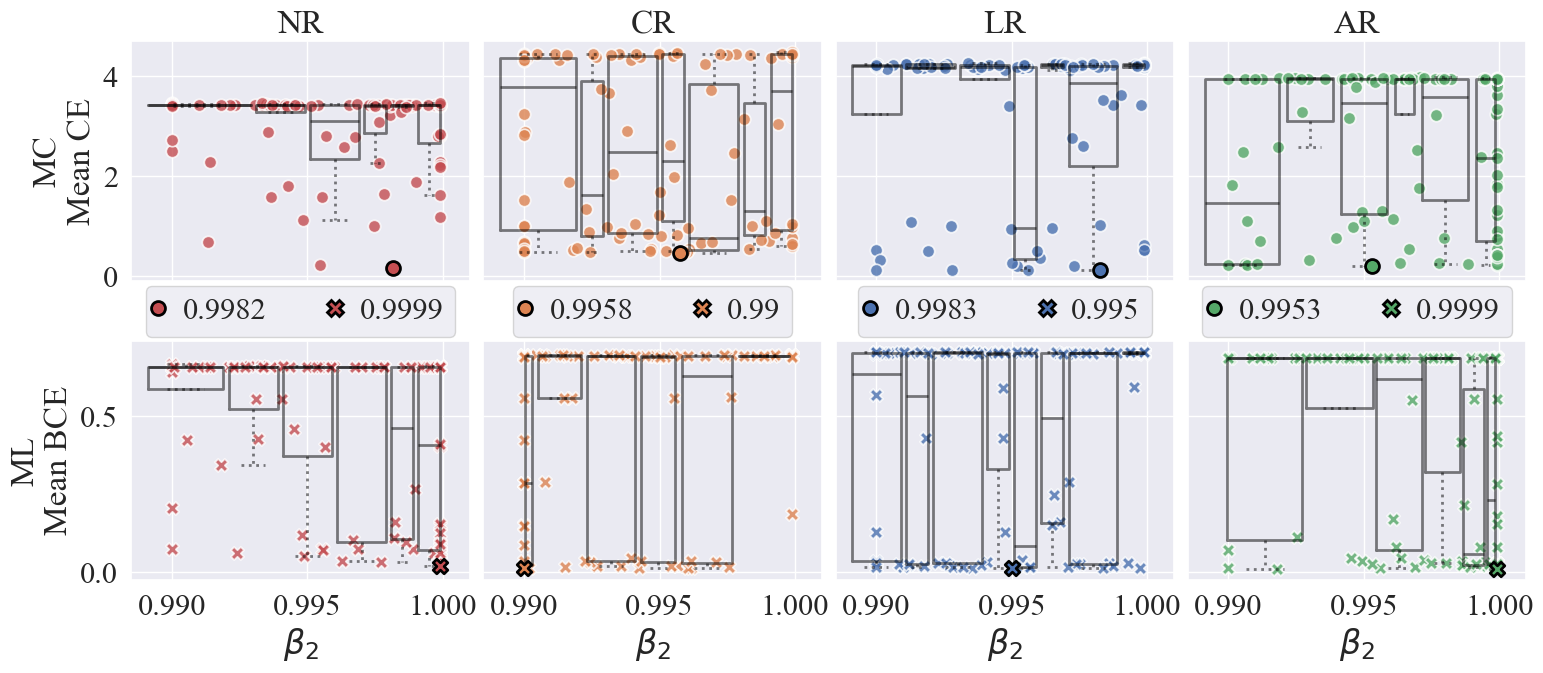

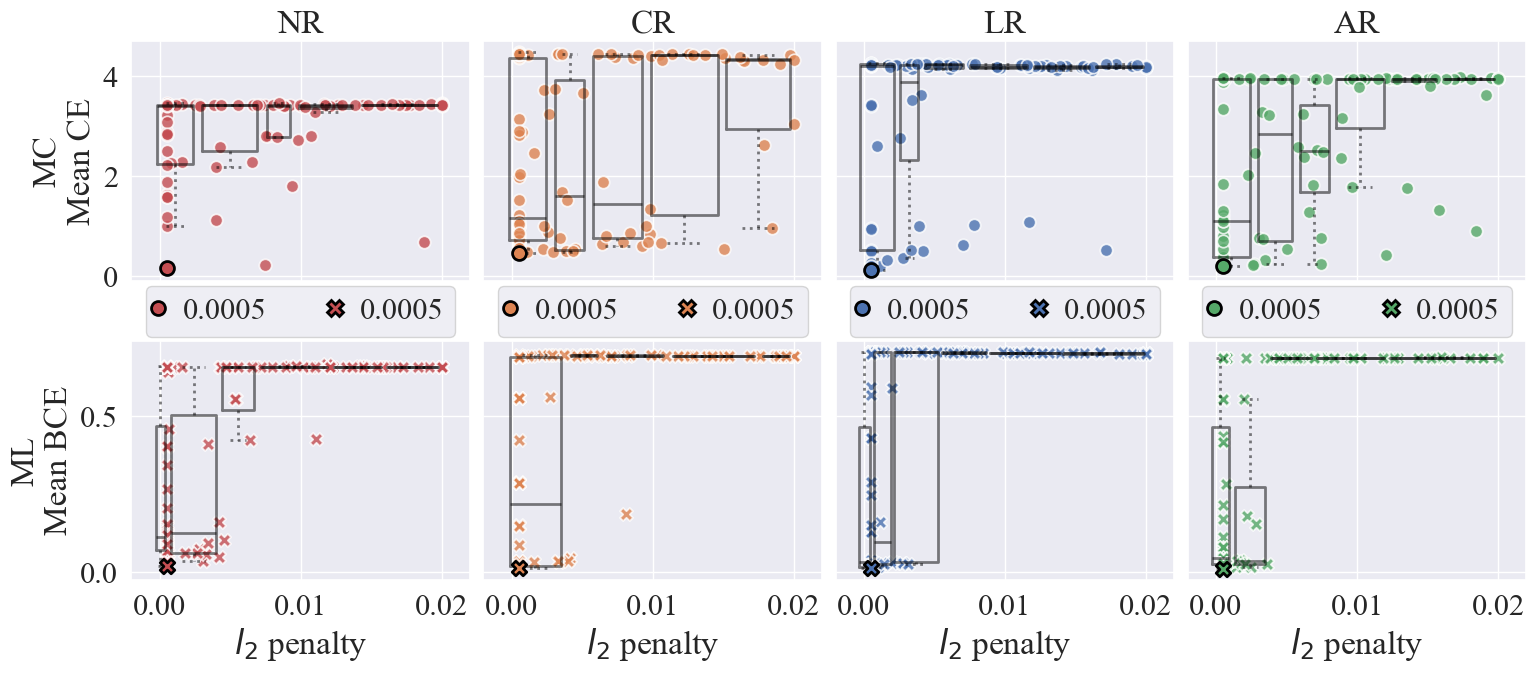

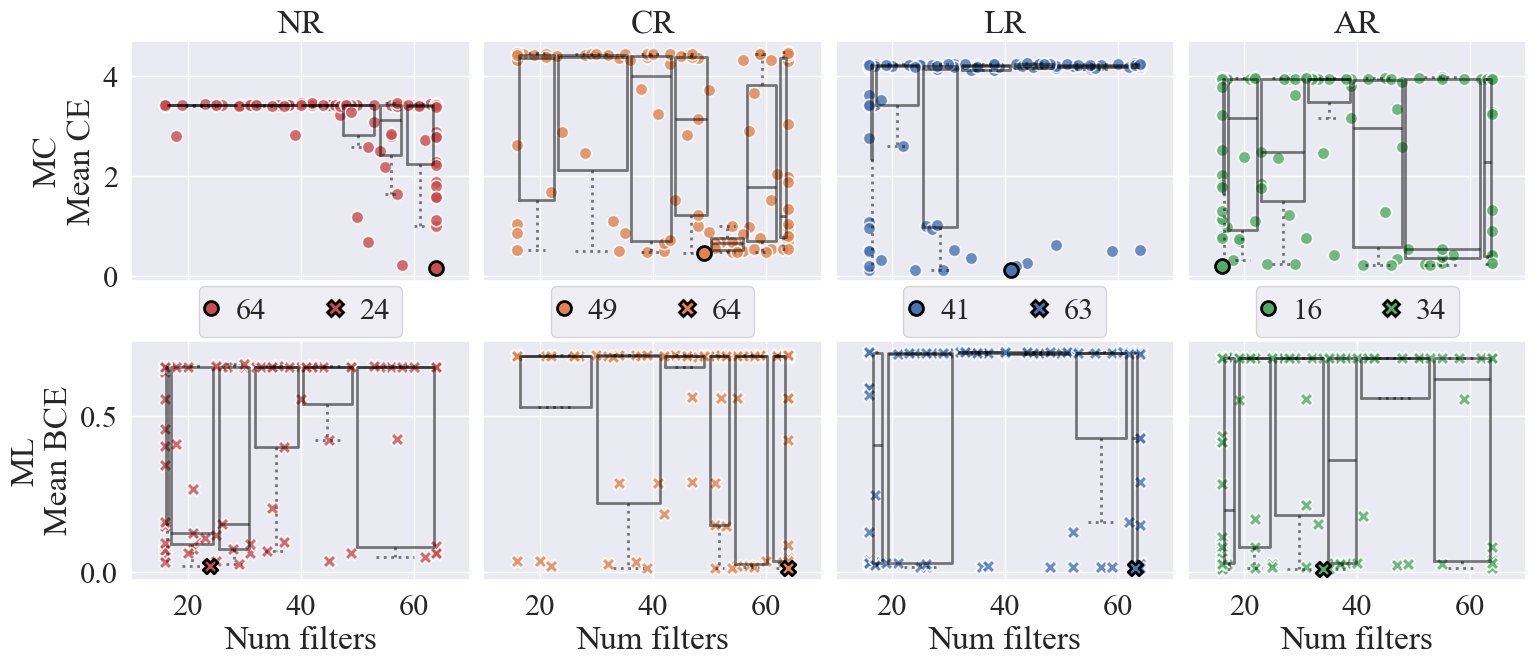

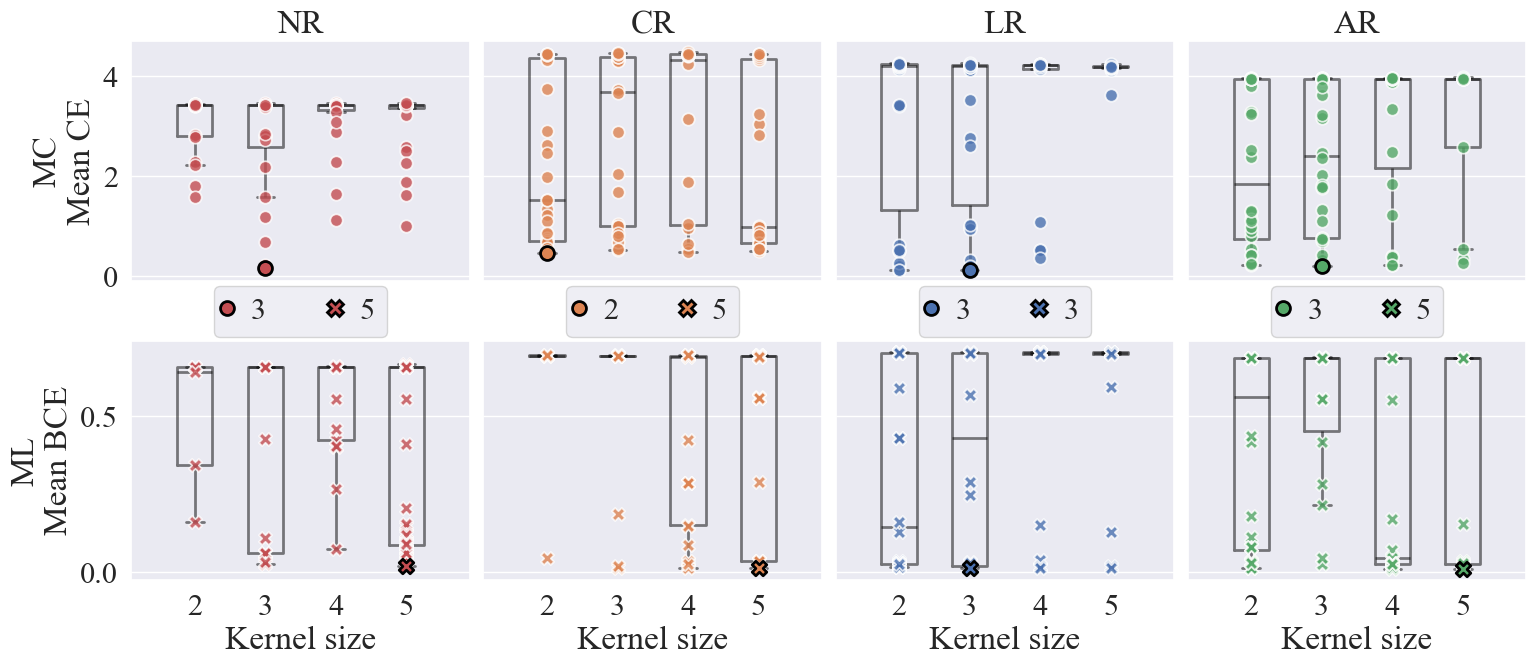

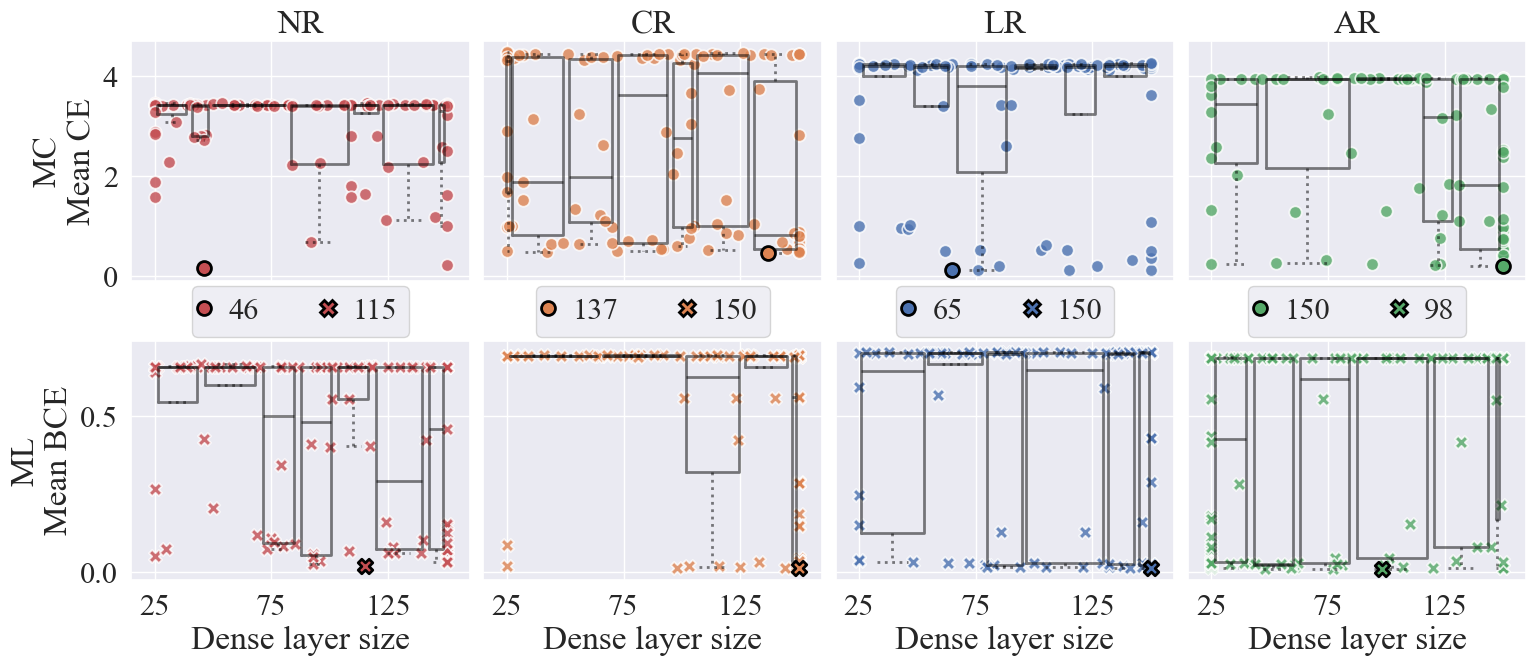

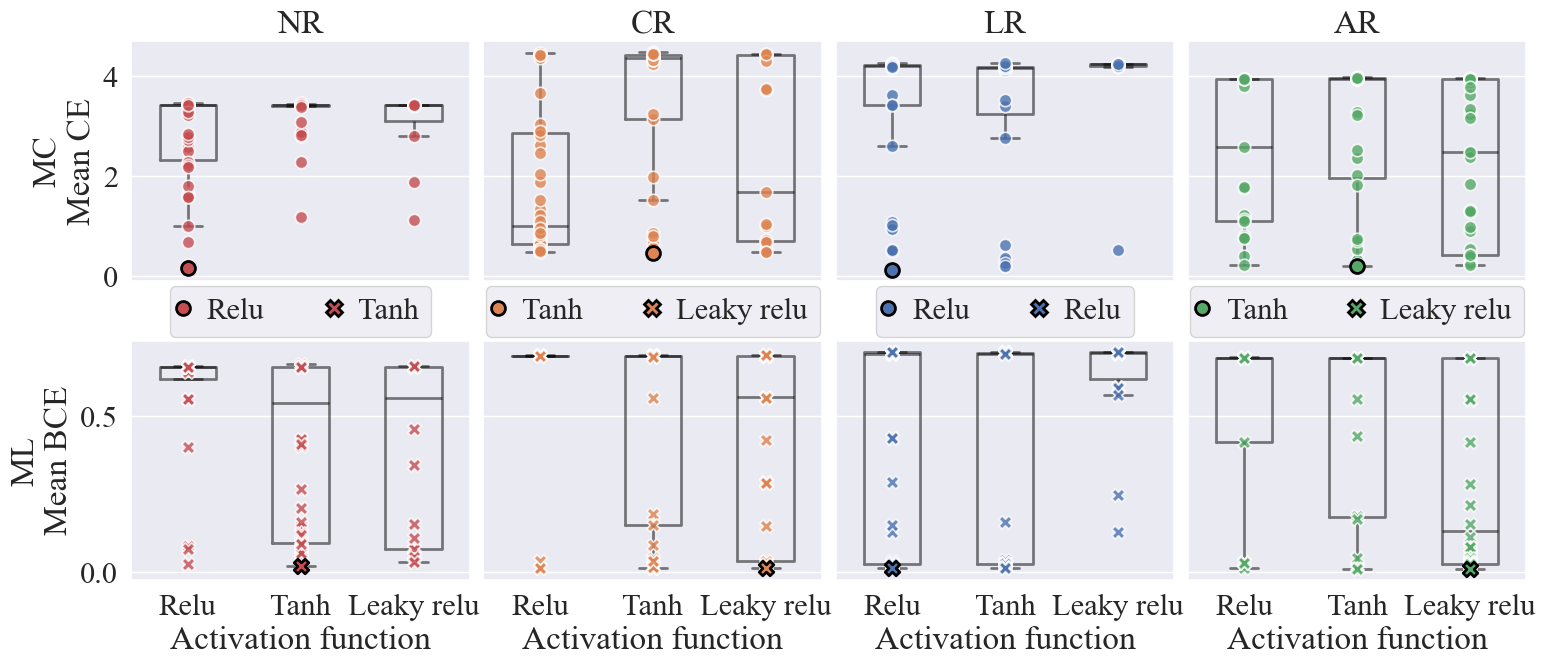

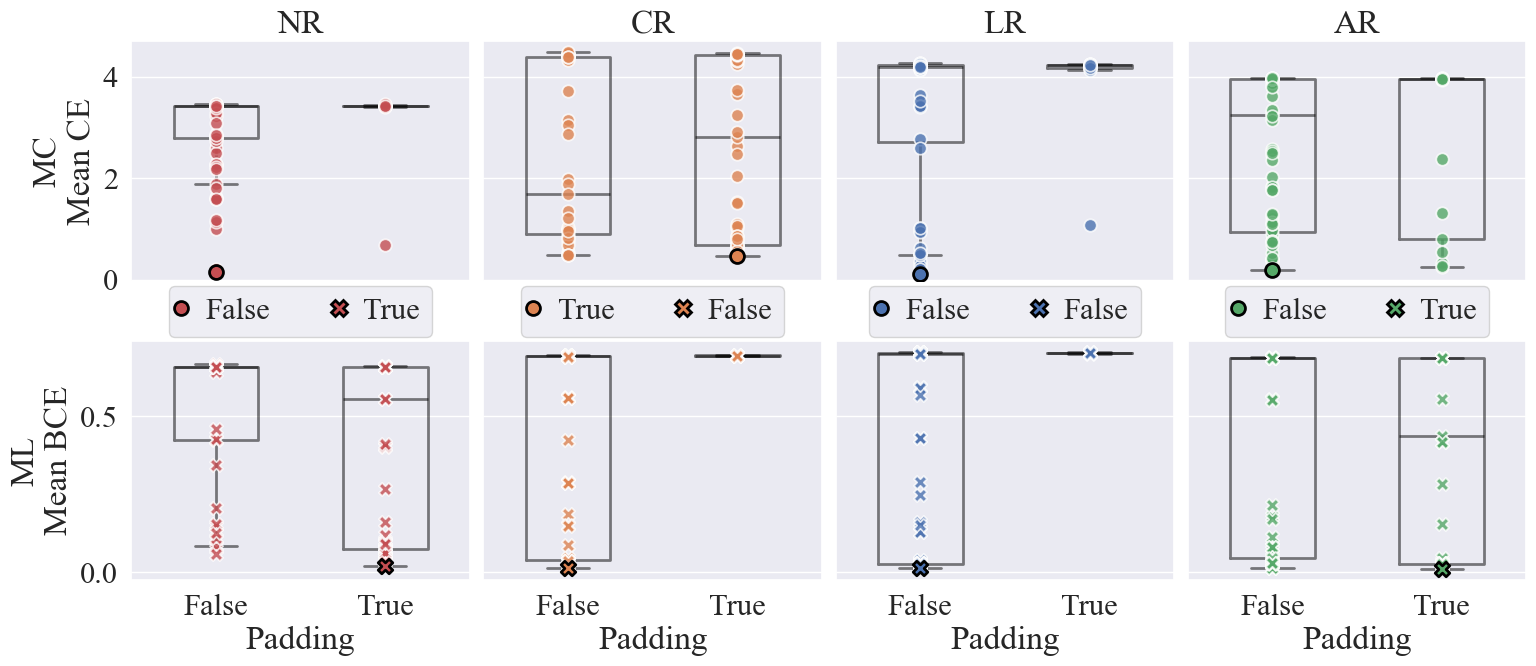

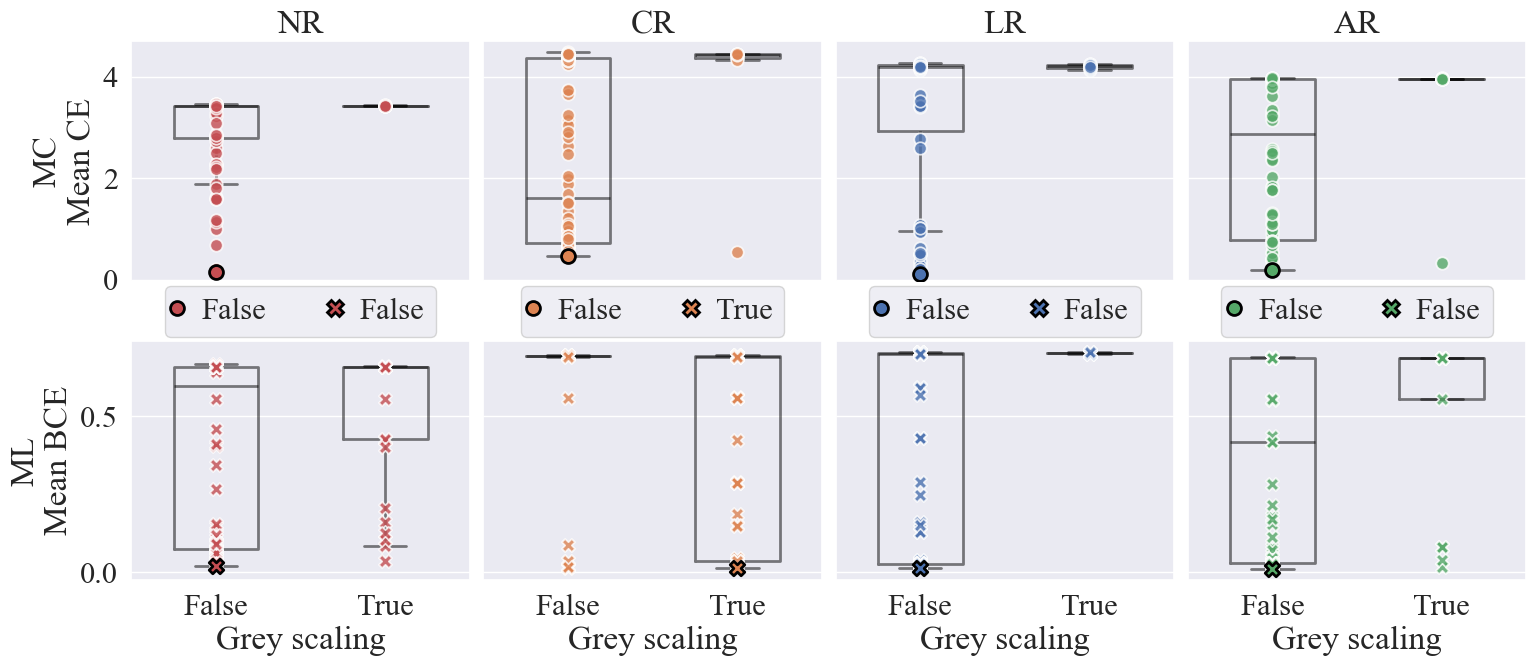

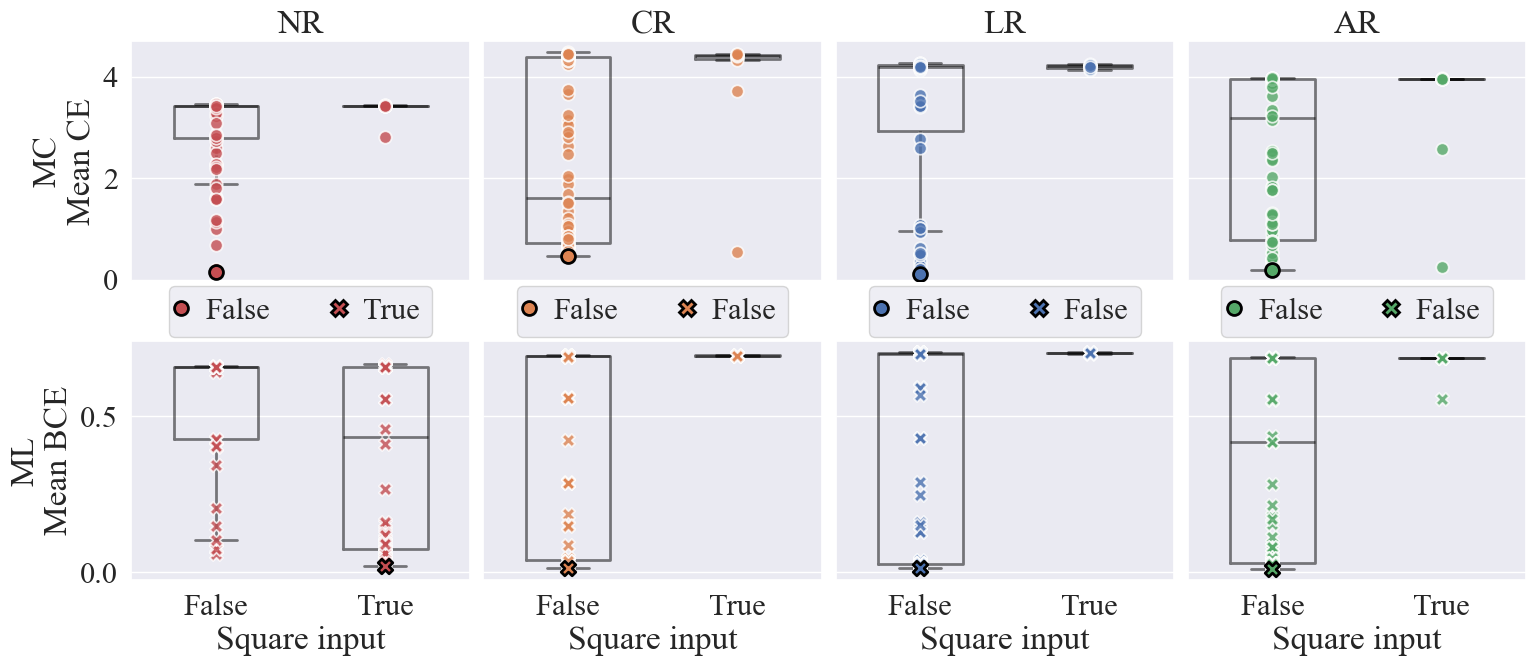

In [47]:

props = {
    'alpha': 0.5,
    'linestyle': ':'
}
props2 = {
    'alpha': 0.5,
    # 'linestyle': ':'
}

quantiles = {
    MODEL_COL: [],
    TRAIN_COL: [],
    "Parameter": [],
    "Bin": [],
    "Frequency": []
}

for p, param in enumerate(param_space.keys()):
    # if param != 'kernel_sz':
    #     continue
    param_name = param_names[p]
    fig, axes = plt.subplots(
        2, 4, figsize=(18, 7), sharey='row', sharex='col'
    )

    for r, resample in enumerate(resamplings):
        model_bests = {}
        for m, model in enumerate(model_types):
            ax = axes[m, r]
            data = frace_aggregate_df[
                    (frace_aggregate_df[TRAIN_COL] == resample) &
                    (frace_aggregate_df[MODEL_COL] == model)
                    ]
            sns.scatterplot(
                data=data,
                x=param_name if param != 'kernel_sz' else data[param_name] - 2,
                y='Mean Validation Loss',
                color=CPAL[r],
                marker=model_markers[model],
                alpha=0.8,
                s=model_sizes[model],
                linewidth=1.25,
                ax=ax, zorder=2,
            )
            best_conf = data[(data['Best Configuration'])]
            best_lbl = param_label[param](best_conf[param_name].values[0])
            model_bests[model] = best_lbl
            
            sns.scatterplot(
                data=best_conf,
                x=param_name if param != 'kernel_sz' else data[param_name] - 2,
                y='Mean Validation Loss',
                color=CPAL[r],
                marker=model_markers[model],
                alpha=1.0,
                edgecolor='black',
                linewidth=2.,
                s=model_sizes[model]+20,
                ax=ax, zorder=4,
            )
            if param in categorical_params:
                sns.boxplot(
                    data=data,
                    x=param_name,
                    y='Mean Validation Loss',
                    fill=False,
                    color=BLACK,
                    width=0.5, linewidth=2.,
                    ax=ax,
                    showfliers=False, zorder=1,
                    boxprops=props2,
                    medianprops=props2,
                    whiskerprops=props2,
                    capprops=props2
                )
            else:
                p_bin = f"{param_name} Binned"
                bin_loc = f"Bin Center"
                data[p_bin] = pd.qcut(data[param_name], q=8, duplicates='drop')
                data[bin_loc] = data[p_bin].apply(lambda x: (x.left + x.right) / 2).astype(float)
                locs = data[bin_loc].unique()
                order = np.argsort(locs)
                nb = locs.shape[0]
                bins = data[p_bin].unique()
                bin_counts = data[p_bin].value_counts()
                min_delta = min([locs[order[i+1]]-locs[order[i]] for i in range(nb-1)])
                
                quantiles[MODEL_COL] = quantiles[MODEL_COL] + [model] * nb
                quantiles[TRAIN_COL] = quantiles[TRAIN_COL] + [resample] * nb
                quantiles["Parameter"] = quantiles["Parameter"] + [param_name] * nb
                quantiles["Bin"] = quantiles["Bin"] + list(bin_counts.index)
                quantiles["Frequency"] = quantiles["Frequency"] + list(bin_counts.values)

                widths = [(bins[i].right - bins[i].left) / min_delta - 0.2 for i in order]
                sns.boxplot(data=data, x=bin_loc, y='Mean Validation Loss', fill=False, color=BLACK, native_scale=True,
                            ax=ax, width=np.array(widths), showfliers=False, zorder=3, linewidth=2.,
                            # flierprops=props,
                            boxprops=props2,
                            medianprops=props2,
                            whiskerprops=props,
                            capprops=props)
            if r == 0 and m == 0:
                ax.set_ylabel(f'{abbreviations[model]}\nMean CE', fontsize=LBL_LARGE)
            if r == 0 and m == 1:
                ax.set_ylabel(f'{abbreviations[model]}\nMean BCE', fontsize=LBL_LARGE)
            if m == 0:
                ax.set_title(f"{abbreviations[resample]}", fontsize=LBL_LARGE)
            if m == 1:
                parf = ("$\\beta_1$" if param_name == 'Beta1'
                        else "$\\beta_2$" if param_name == 'Beta2'
                        else "$l_2$ penalty" if param_name == "L2 penalty"
                        else param_name)
                ax.set_xlabel(parf, fontsize=LBL_LARGE)
                if param in x_locators:
                    lc = x_locators[param]
                    ax.xaxis.set_major_locator(lc[0])
                    ax.set_xlim(lc[1][0], lc[1][1])
            ax.tick_params(axis='both', labelsize=LBL_SIZE)
                    
        handles = [
            Line2D([0], [0], color=CPAL[r],
                linewidth=1., markersize=model_sizes[mod]//8,
                marker=model_markers[mod], markeredgecolor=BLACK,
                markeredgewidth=2.,
                linestyle='none',
                # label=f'{abbreviations[mod]}: {model_bests[mod]}'
                label=f'{model_bests[mod]}'
            ) for m, mod in enumerate(model_types)
        ]
        ax = axes[1, r]
        xl = 0.025
        ax.legend(
            handles=handles,
            labels=[h.get_label() for h in handles],
            loc='lower center',
            ncols=2, columnspacing=2.25,
            bbox_to_anchor=(0.5, 0.95),
            handlelength=0.,
            fontsize=LBL_SIZE
        )
    plt.subplots_adjust(hspace=0.25, wspace=0.04)
    # plt.tight_layout()
    plt.savefig(os.path.join(PLOTS, 'hyperparams', f"frace_{param}_results_{version}.pdf"), bbox_inches='tight')
    # break

In [30]:
[(k, len(v)) for k, v in quantiles.items()]

[('Model', 291),
 ('Resampling Scenario', 291),
 ('Parameter', 291),
 ('Bin', 291),
 ('Frequency', 291)]

In [186]:
quant_df = pd.DataFrame(quantiles)
quant_df

Model Resampling Scenario         Parameter                 Bin  \
0    Multiclass       No Resampling     Learning Rate  (-0.0009, 0.00167]   
1    Multiclass       No Resampling     Learning Rate  (0.00167, 0.00337]   
2    Multiclass       No Resampling     Learning Rate   (0.00337, 0.0053]   
3    Multiclass       No Resampling     Learning Rate   (0.0053, 0.00737]   
4    Multiclass       No Resampling     Learning Rate     (0.00737, 0.01]   
..          ...                 ...               ...                 ...   
286  Multilabel  Adaptive Resampled  Dense Layer Size      (85.75, 119.0]   
287  Multilabel  Adaptive Resampled  Dense Layer Size      (41.625, 61.5]   
288  Multilabel  Adaptive Resampled  Dense Layer Size       (61.5, 85.75]   
289  Multilabel  Adaptive Resampled  Dense Layer Size     (145.25, 150.0]   
290  Multilabel  Adaptive Resampled  Dense Layer Size     (119.0, 145.25]   

     Frequency  
0           48  
1           12  
2           12  
3           12  
4           12  
..         ...  
286         13  
287         12  
288         12  
289         12  
290         11  

[291 rows x 5 columns]

In [193]:
quant_df.groupby([MODEL_COL, TRAIN_COL, "Parameter"]).agg({
    "Bin": lambda f: len(f),
    "Frequency": lambda f: ", ".join([str(ff) for ff in np.unique(f)])
})

Bin              Frequency
Model      Resampling Scenario Parameter                                   
Multiclass Adaptive Resampled  Beta1               6                 12, 36
                               Beta2               6                 12, 36
                               Dense Layer Size    5             12, 13, 47
                               L2 Penalty          6                 12, 36
                               Learning Rate       6                 12, 36
                               Num Filters         7     10, 11, 12, 15, 24
           Class Resampled     Beta1               7                 12, 24
                               Beta2               7                 12, 24
                               Dense Layer Size    7         11, 12, 13, 24
                               L2 Penalty          5                 12, 48
                               Learning Rate       6                 12, 36
                               Num Filters         7         11, 12, 13, 24
           Label Resampled     Beta1               6                 12, 36
                               Beta2               7                 12, 24
                               Dense Layer Size    6         11, 12, 13, 24
                               L2 Penalty          6                 12, 36
                               Learning Rate       7                 12, 24
                               Num Filters         7         11, 12, 13, 24
           No Resampling       Beta1               7                 12, 24
                               Beta2               6                 12, 24
                               Dense Layer Size    7      8, 12, 13, 15, 24
                               L2 Penalty          5             12, 24, 36
                               Learning Rate       5                 12, 48
                               Num Filters         6         11, 12, 13, 36
Multilabel Adaptive Resampled  Beta1               5                 12, 48
                               Beta2               6                 12, 36
                               Dense Layer Size    6         11, 12, 13, 36
                               L2 Penalty          5                 12, 48
                               Learning Rate       6                 12, 36
                               Num Filters         6         11, 12, 13, 36
           Class Resampled     Beta1               6                 12, 36
                               Beta2               6                 12, 24
                               Dense Layer Size    5                 12, 48
                               L2 Penalty          5                 12, 48
                               Learning Rate       6                 12, 36
                               Num Filters         6         11, 12, 13, 36
           Label Resampled     Beta1               5                 12, 48
                               Beta2               8                     12
                               Dense Layer Size    6                 12, 36
                               L2 Penalty          6                 12, 36
                               Learning Rate       6                 12, 36
                               Num Filters         6     11, 12, 13, 23, 24
           No Resampling       Beta1               6                 12, 36
                               Beta2               6                 12, 36
                               Dense Layer Size    7             12, 13, 23
                               L2 Penalty          6                 12, 36
                               Learning Rate       5                 12, 48
                               Num Filters         6  9, 11, 12, 13, 15, 36

<Axes: xlabel='L2 Penalty', ylabel='Mean Validation Loss'>

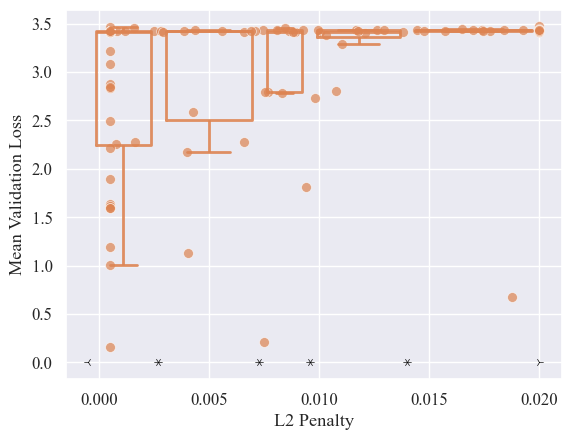

In [207]:
param = list(param_space.keys())[3]
param_name = param_names[3]
    
data = frace_aggregate_df[
        (frace_aggregate_df[TRAIN_COL] == BASE) &
        (frace_aggregate_df[MODEL_COL] == MC)
        ]
p_bin = f"{param_name} Binned"
bin_loc = f"Bin Center"
data[p_bin] = pd.qcut(data[param_name], q=8, duplicates='drop')
data[bin_loc] = data[p_bin].apply(lambda x: (x.left + x.right) / 2).astype(float)
locs = data[bin_loc].unique()
order = np.argsort(locs)
bins = data[p_bin].unique()
min_delta = min([locs[order[i+1]]-locs[order[i]] for i in range(locs.shape[0]-1)])

widths = [(bins[i].right - bins[i].left) / min_delta - 0.2 for i in order]

sns.scatterplot(
    data=data,
    x=param_name if param != 'kernel_sz' else data[param_name] - 2,
    y='Mean Validation Loss',
    color=CPAL[1],
    marker=model_markers[MC],
    alpha=0.7,
    s=50,
    linewidth=0.5,
    # ax=ax
)
props = {
    'alpha': 0.9,
    'linestyle': '-'
}
sns.boxplot(data=data, x=bin_loc, y='Mean Validation Loss', zorder=3, fill=False, color=CPAL[1], native_scale=True,
            width=np.array(widths),  linewidth=2., showfliers=False,
            # gap=0.,
            flierprops=props,
            boxprops=props,
            medianprops=props,
            whiskerprops=props,
            capprops=props)

lefts = [b.left for b in data[p_bin].unique()]
rights = [b.right for b in data[p_bin].unique()]

sns.scatterplot(x=lefts, y=[l*0.01 for l in lefts], color=BLACK, marker='3')
sns.scatterplot(x=rights, y=[l*0.01 for l in lefts], color=BLACK, marker='4')


In [217]:
x_idx = data[param_name]


quantiles = np.linspace(0, 1, 8 + 1)

bins = x_idx.dropna().quantile(quantiles)
bins

0.000    0.000500
0.125    0.000500
0.250    0.000500
0.375    0.002692
0.500    0.007274
0.625    0.009568
0.750    0.013979
0.875    0.020000
1.000    0.020000
Name: L2 Penalty, dtype: float64

In [212]:

import pandas.core.algorithms as algos

X: -0.0005, W: 1.001, barwidth: 0.4
X: 0.000951, W: 1.248, barwidth: 0.6
X: 0.00276, W: 0.752, barwidth: 0.4
X: 0.00385, W: 2.049, barwidth: 0.8
X: 0.00682, W: 1.883, barwidth: 0.8
X: 0.00955, W: 1.414, barwidth: 0.6
X: 0.0116, W: 3.311, barwidth: 1.0
X: 0.0164, W: 2.484, barwidth: 1.0


(0.5, 1.5)

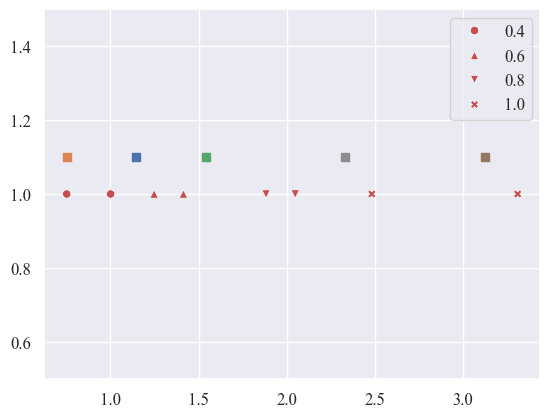

In [ ]:
locs = data[bin_loc].unique()
order = np.argsort(locs)
bins = data[p_bin].unique()
min_delta = min([locs[order[i+1]]-locs[order[i]] for i in range(locs.shape[0]-1)])

lefts = [bins[i].left for i in order]
widths = [(bins[i].right - bins[i].left) / min_delta for i in order]
m = np.mean(widths)
mn = np.min(widths)
st = np.std(widths)
diffs = [w-mn for w in widths]
barwidth = [0.4 if d < 0.5*st else 0.6 if d < st else 0.8 if d < 2*st else 1. for d in diffs]
markers = ['o', '^', 'v', 'X']

[print(f"X: {x:.4}, W: {w:.4}, barwidth: {b:.4}") for x, w, b in zip(lefts, widths, barwidth)]

sns.scatterplot(x=widths, y=[1]*8, style=barwidth, markers=markers, color=CPAL[0])
plt.scatter(x=[mn], y=[1.1], marker='s', color=CPAL[1])
plt.scatter(x=[mn+0.5*st], y=[1.1], marker='s', color=CPAL[2])
plt.scatter(x=[mn+st], y=[1.1], marker='s', color=CPAL[3])
plt.scatter(x=[mn+2*st], y=[1.1], marker='s', color=CPAL[4])
plt.scatter(x=[mn+3*st], y=[1.1], marker='s', color=CPAL[5])
plt.ylim(0.5, 1.5)

In [116]:
best_conf["Mean Validation Loss"].values[0]

0.15514101777225733

In [49]:
main_params = param_names[:-2]
main_params

['Learning rate',
 'Beta1',
 'Beta2',
 'L2 penalty',
 'Num filters',
 'Kernel size',
 'Dense layer size',
 'Activation function',
 'Padding']

### MDS

In [273]:
frace_aggregate_df[af].value_counts()

Activation function
Relu          279
Tanh          275
Leaky relu    214
Name: count, dtype: int64

In [354]:
VAL_COL = 'Mean Validation Loss'
idx = ["ID", "Configuration ID"] + main_params
gb = [TRAIN_COL, MODEL_COL]

def normalised_performance(group, maxp):
    met = tuple(group[gb].iloc[0].to_list())
    group[VAL_COL] = group[VAL_COL] / maxp.loc[met].iloc[0]
    return group

frace_config_distances = frace_aggregate_df.copy()
frace_config_distances["ID"] = frace_config_distances.apply(
    lambda row: f"{abbreviations[row[TRAIN_COL]]}_{abbreviations[row[MODEL_COL]]}_{row['Configuration ID']}",
    axis=1
)
frace_config_distances.drop(columns=['Best Configuration', "Grey scaling", "Square Input"], inplace=True)
frace_config_distances.set_index(idx, inplace=True)

max_perf = frace_config_distances.groupby(gb).agg('max')
norm_vals = frace_config_distances.groupby(gb).apply(normalised_performance, maxp=max_perf)[VAL_COL].reset_index().set_index(idx + gb)
frace_config_distances = frace_config_distances.reset_index().set_index(idx + gb)
frace_config_distances["Normalised Loss"] = norm_vals
frace_config_distances.reset_index(inplace=True)

for pn in main_params:
    if pn in [si, gs]:
        continue
    elif pn == af:
        frace_config_distances[pn] = frace_config_distances[pn].apply(
            lambda r: 0. if r == 'Relu' else 2. if r == 'Tanh' else 1.)
    elif pn == pa:
        frace_config_distances[pn] = frace_config_distances[pn].apply(
            lambda r: float(r))
    else:
        mn = frace_config_distances[pn].min()
        mx = frace_config_distances[pn].max()
        frace_config_distances[pn] = frace_config_distances[pn].apply(lambda r: (r-mn) / (mx-mn))
        
frace_config_distances = frace_config_distances.set_index("ID")[
    gb + ["Configuration ID"] + main_params + [VAL_COL, "Normalised Loss"]
]
        
frace_config_distances.head(10)
# max_perf

C:\Users\User\AppData\Local\Temp\ipykernel_14192\942610393.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  norm_vals = frace_config_distances.groupby(gb).apply(normalised_performance, maxp=max_perf)[VAL_COL].reset_index().set_index(idx + gb)


Resampling Scenario       Model  Configuration ID  Learning Rate  \
ID                                                                         
AR_MC_0  Adaptive Resampled  Multiclass                 0       0.272644   
AR_MC_1  Adaptive Resampled  Multiclass                 1       0.658367   
AR_MC_2  Adaptive Resampled  Multiclass                 2       0.883576   
AR_MC_3  Adaptive Resampled  Multiclass                 3       0.060375   
AR_MC_4  Adaptive Resampled  Multiclass                 4       0.229720   
AR_MC_5  Adaptive Resampled  Multiclass                 5       0.841924   
AR_MC_6  Adaptive Resampled  Multiclass                 6       0.614027   
AR_MC_7  Adaptive Resampled  Multiclass                 7       0.439306   
AR_MC_8  Adaptive Resampled  Multiclass                 8       0.426531   
AR_MC_9  Adaptive Resampled  Multiclass                 9       0.501825   

            Beta1     Beta2  L2 Penalty  Num Filters  Kernel Size  \
ID                                                                  
AR_MC_0  0.229945  0.593419    0.517585     0.312500     0.000000   
AR_MC_1  0.537796  0.183910    0.272580     0.666667     1.000000   
AR_MC_2  0.361387  0.953319    0.899948     0.958333     0.666667   
AR_MC_3  0.937306  0.300572    0.152903     0.041667     0.333333   
AR_MC_4  0.385828  0.061291    0.113709     0.166667     0.333333   
AR_MC_5  0.819172  0.716037    0.860773     0.812500     1.000000   
AR_MC_6  0.018003  0.423190    0.499991     0.541667     0.666667   
AR_MC_7  0.718437  0.830701    0.745007     0.458333     0.333333   
AR_MC_8  0.290113  0.484555    0.763568     0.729167     0.333333   
AR_MC_9  0.973457  0.769366    0.008767     0.250000     0.666667   

         Dense Layer Size  Activation function  Padding  Mean Validation Loss  \
ID                                                                              
AR_MC_0             0.840                  1.0      1.0              3.954759   
AR_MC_1             0.016                  0.0      0.0              2.583850   
AR_MC_2             0.688                  2.0      0.0              3.954846   
AR_MC_3             0.392                  2.0      1.0              0.328711   
AR_MC_4             0.552                  2.0      0.0              0.242760   
AR_MC_5             0.368                  2.0      1.0              3.978036   
AR_MC_6             0.912                  1.0      1.0              3.955585   
AR_MC_7             0.224                  0.0      0.0              3.951414   
AR_MC_8             0.576                  2.0      0.0              3.967487   
AR_MC_9             0.248                  2.0      1.0              3.935956   

         Normalised Loss  
ID                        
AR_MC_0         0.994149  
AR_MC_1         0.649529  
AR_MC_2         0.994171  
AR_MC_3         0.082631  
AR_MC_4         0.061025  
AR_MC_5         1.000000  
AR_MC_6         0.994356  
AR_MC_7         0.993308  
AR_MC_8         0.997348  
AR_MC_9         0.989422

In [355]:
main_params

['Learning Rate',
 'Beta1',
 'Beta2',
 'L2 Penalty',
 'Num Filters',
 'Kernel Size',
 'Dense Layer Size',
 'Activation function',
 'Padding']

In [356]:
def euclid(x, y):
    # print(x, y)
    return (x - y) ** 2

def jaccard(x, y):
    return int(x != y)

def config_distance(s1, s2):
    ssd = 0.
    sd = []
    for pn in main_params:
        # if pn in [si, gs]:
        #     continue
        if pn in [af, pa]:
            sd.append(jaccard(s1[pn], s2[pn]))
        else:
            sd.append(euclid(s1[pn], s2[pn]))
    return np.sqrt(sum(sd)), sd

def config_distance_np(s1, s2):
    # print(s1, s2)
    # print(type(s1))
    ssd = 0.
    sd = []
    for p in range(len(main_params)):
        # if pn in [si, gs]:
        #     continue
        if p > 6:
            sd.append(jaccard(s1[p], s2[p]))
        else:
            sd.append(euclid(s1[p], s2[p]))
    return np.sqrt(sum(sd))

In [323]:
config_distance(frace_config_distances.iloc[0], frace_config_distances.iloc[1])

(2.0677741591584535,
 [0.14878163670623673,
  0.0947727902533238,
  0.16769805692466838,
  0.060027461621443075,
  0.12543402777777776,
  1.0,
  0.6789759999999999,
  1,
  1])

In [357]:
frace_X = frace_config_distances[main_params].to_numpy()
frace_Y = frace_config_distances["Normalised Loss"].to_numpy()
frace_idx = frace_config_distances.index.to_numpy()

In [358]:
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [359]:
frace_dists = pairwise_distances(
    X=frace_X,
    metric=config_distance_np
)

In [360]:
mds = MDS(
    n_components=2, 
    metric=True,
    n_init=4,
    max_iter=300,
    verbose=0,
    eps=1e-06,
    n_jobs=None,
    random_state=123,
    dissimilarity='precomputed',
    normalized_stress='auto'
)

frace_mds = mds.fit_transform(frace_dists)
frace_mds.shape

(768, 2)

In [361]:
tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric=config_distance_np,
    metric_params=None,
    init='pca',
    verbose=0,
    random_state=456,
    method='barnes_hut',
    angle=0.5,
    n_jobs=None
)

frace_tsne = tsne.fit_transform(frace_X)
frace_tsne.shape

(768, 2)

In [362]:
pca = PCA(
    n_components=None,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    n_oversamples=10,
    power_iteration_normalizer='auto',
    random_state=789
)

frace_pca = pca.fit_transform(frace_X)
frace_pca.shape

(768, 9)

In [363]:
frace_config_distances["M0"] = frace_mds[:,0]
frace_config_distances["M1"] = frace_mds[:,1]

frace_config_distances["T0"] = frace_tsne[:,0]
frace_config_distances["T1"] = frace_tsne[:,1]

frace_config_distances["P0"] = frace_pca[:,0]
frace_config_distances["P1"] = frace_pca[:,1]

In [364]:
frace_config_distances.head()

Resampling Scenario       Model  Configuration ID  Learning Rate  \
ID                                                                         
AR_MC_0  Adaptive Resampled  Multiclass                 0       0.272644   
AR_MC_1  Adaptive Resampled  Multiclass                 1       0.658367   
AR_MC_2  Adaptive Resampled  Multiclass                 2       0.883576   
AR_MC_3  Adaptive Resampled  Multiclass                 3       0.060375   
AR_MC_4  Adaptive Resampled  Multiclass                 4       0.229720   

            Beta1     Beta2  L2 Penalty  Num Filters  Kernel Size  \
ID                                                                  
AR_MC_0  0.229945  0.593419    0.517585     0.312500     0.000000   
AR_MC_1  0.537796  0.183910    0.272580     0.666667     1.000000   
AR_MC_2  0.361387  0.953319    0.899948     0.958333     0.666667   
AR_MC_3  0.937306  0.300572    0.152903     0.041667     0.333333   
AR_MC_4  0.385828  0.061291    0.113709     0.166667     0.333333   

         Dense Layer Size  Activation function  Padding  Mean Validation Loss  \
ID                                                                              
AR_MC_0             0.840                  1.0      1.0              3.954759   
AR_MC_1             0.016                  0.0      0.0              2.583850   
AR_MC_2             0.688                  2.0      0.0              3.954846   
AR_MC_3             0.392                  2.0      1.0              0.328711   
AR_MC_4             0.552                  2.0      0.0              0.242760   

         Normalised Loss        M0        M1         T0         T1        P0  \
ID                                                                             
AR_MC_0         0.994149 -0.042434  0.987947   6.543817  23.093479  0.041763   
AR_MC_1         0.649529  0.646512 -0.635380 -18.782156   7.296652 -0.990436   
AR_MC_2         0.994171 -1.084945 -0.579019  26.013922  -2.550082  0.985997   
AR_MC_3         0.082631 -0.971088  0.654978  22.261082  22.328459  1.051165   
AR_MC_4         0.061025 -0.472176 -0.194467  10.575337  -6.112274  0.983092   

               P1  
ID                 
AR_MC_0  0.583870  
AR_MC_1 -0.114321  
AR_MC_2 -0.286235  
AR_MC_3  0.403137  
AR_MC_4 -0.317150

C:\Users\User\AppData\Local\Temp\ipykernel_14192\404234483.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(
C:\Users\User\AppData\Local\Temp\ipykernel_14192\404234483.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(
C:\Users\User\AppData\Local\Temp\ipykernel_14192\404234483.py:17: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


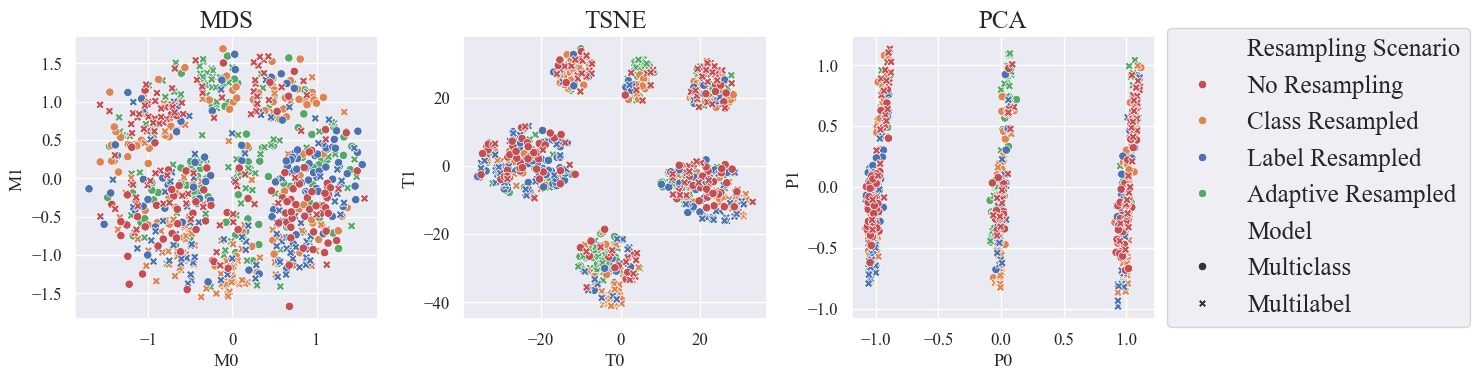

In [367]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.scatterplot(
    data=frace_config_distances,
    x="M0", y="M1", ax=axes[0], legend=False,
    hue=TRAIN_COL, hue_order=resamplings, palette=CPAL,
    style=MODEL_COL, markers=model_markers)


sns.scatterplot(
    data=frace_config_distances,
    x="T0", y="T1", ax=axes[1], legend=False,
    hue=TRAIN_COL, hue_order=resamplings, palette=CPAL,
    style=MODEL_COL, markers=model_markers)


sns.scatterplot(
    data=frace_config_distances,
    x="P0", y="P1", ax=axes[2],
    hue=TRAIN_COL, hue_order=resamplings, palette=CPAL,
    style=MODEL_COL, markers=model_markers)


axes[0].set_title("MDS", fontsize=LBL_SIZE)
axes[1].set_title("TSNE", fontsize=LBL_SIZE)
axes[2].set_title("PCA", fontsize=LBL_SIZE)
axes[2].legend(loc='center left', bbox_to_anchor=(1., 0.5), fontsize=LBL_SIZE)
plt.tight_layout()

<Axes: xlabel='X0', ylabel='X1'>

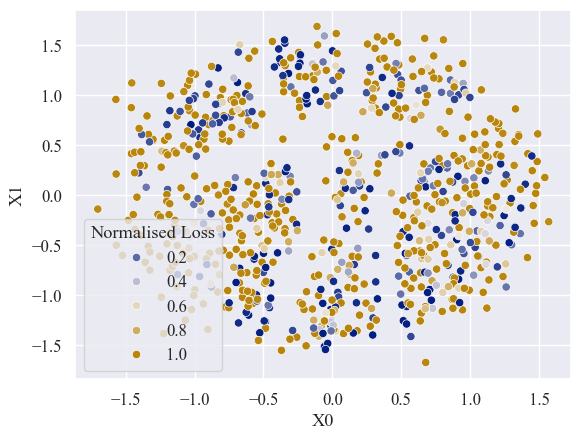

In [332]:
sns.scatterplot(
    data=frace_config_distances,
    x="X0", y="X1",
    hue="Normalised Loss", palette=CTS_PAL)

In [339]:

import matplotlib.tri as tri

In [368]:
xm, ym, z = frace_config_distances["M0"], frace_config_distances["M1"], frace_config_distances["Normalised Loss"]
xt, yt = frace_config_distances["T0"], frace_config_distances["T1"]
xp, yp = frace_config_distances["P0"], frace_config_distances["P1"]



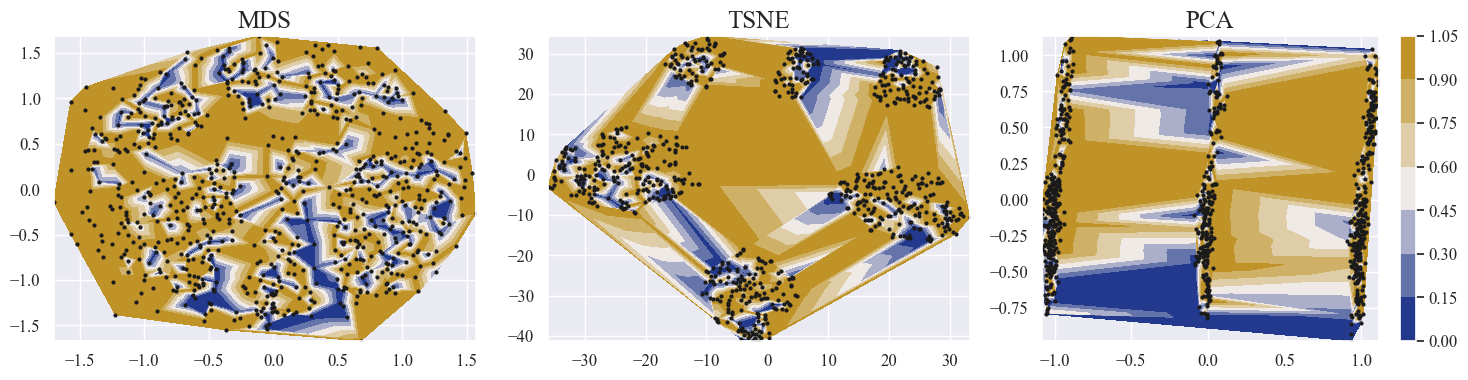

In [370]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].tricontourf(xm, ym, z, levels=8, cmap=CTS_PAL)
axes[0].plot(xm, ym, 'ko', ms=2)
axes[1].tricontourf(xt, yt, z, levels=8, cmap=CTS_PAL)
axes[1].plot(xt, yt, 'ko', ms=2)
ctr = axes[2].tricontourf(xp, yp, z, levels=8, cmap=CTS_PAL)
axes[2].plot(xp, yp, 'ko', ms=2)


axes[0].set_title("MDS", fontsize=LBL_SIZE)
axes[1].set_title("TSNE", fontsize=LBL_SIZE)
axes[2].set_title("PCA", fontsize=LBL_SIZE)
fig.colorbar(ctr, ax=axes[2])
plt.tight_layout()

C:\Users\User\AppData\Local\Temp\ipykernel_14192\1326875618.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1800x700 with 8 Axes> which fig.colorbar is called on.
  fig.colorbar(cntr2)


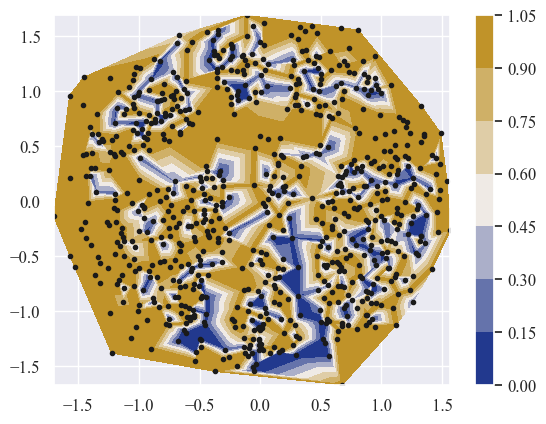

In [345]:

# plt.tricontour(frace_config_distances["X0"], frace_config_distances["X1"], frace_config_distances["Normalised Loss"], levels=14, linewidths=0.5, colors='k')
cntr2 = plt.tricontourf(frace_config_distances["X0"], frace_config_distances["X1"], frace_config_distances["Normalised Loss"], levels=8, cmap=CTS_PAL)

fig.colorbar(cntr2)
plt.plot(frace_config_distances["X0"], frace_config_distances["X1"], 'ko', ms=3)

### Feature Importance

In [50]:
VAL_COL = 'Mean Validation Loss'
idx = ["ID", "Configuration ID"] + main_params
gb = [TRAIN_COL, MODEL_COL]

def normalised_performance(group, maxp):
    met = tuple(group[gb].iloc[0].to_list())
    group[VAL_COL] = group[VAL_COL] / maxp.loc[met].iloc[0]
    return group

frace_config_normed = frace_aggregate_df.copy()
frace_config_normed["ID"] = frace_config_normed.apply(
    lambda row: f"{abbreviations[row[TRAIN_COL]]}_{abbreviations[row[MODEL_COL]]}_{row['Configuration ID']}",
    axis=1
)
frace_config_normed.drop(columns=['Best Configuration', gs, si], inplace=True)
frace_config_normed.set_index(idx, inplace=True)

max_perf = frace_config_normed.groupby(gb).agg('max')
norm_vals = frace_config_normed.groupby(gb).apply(normalised_performance, maxp=max_perf)[VAL_COL].reset_index().set_index(idx + gb)
frace_config_normed = frace_config_normed.reset_index().set_index(idx + gb)
frace_config_normed["Normalised Loss"] = norm_vals
frace_config_normed.reset_index(inplace=True)

frace_config_normed.head()

C:\Users\User\AppData\Local\Temp\ipykernel_24212\1675968690.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  norm_vals = frace_config_normed.groupby(gb).apply(normalised_performance, maxp=max_perf)[VAL_COL].reset_index().set_index(idx + gb)


ID  Configuration ID  Learning rate     Beta1     Beta2  L2 penalty  \
0  AR_MC_0                 0       0.002799  0.872994  0.995875    0.010593   
1  AR_MC_1                 1       0.006618  0.903780  0.991821    0.005815   
2  AR_MC_2                 2       0.008847  0.886139  0.999438    0.018049   
3  AR_MC_3                 3       0.000698  0.943731  0.992976    0.003482   
4  AR_MC_4                 4       0.002374  0.888583  0.990607    0.002717   

   Num filters  Kernel size  Dense layer size Activation function  Padding  \
0           31            2               130          Leaky relu     True   
1           48            5                27                Relu    False   
2           62            4               111                Tanh    False   
3           18            3                74                Tanh     True   
4           24            3                94                Tanh    False   

  Resampling Scenario       Model  Mean Validation Loss  Normalised Loss  
0  Adaptive Resampled  Multiclass              3.954759         0.994149  
1  Adaptive Resampled  Multiclass              2.583850         0.649529  
2  Adaptive Resampled  Multiclass              3.954846         0.994171  
3  Adaptive Resampled  Multiclass              0.328711         0.082631  
4  Adaptive Resampled  Multiclass              0.242760         0.061025

In [51]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error

In [52]:
frace_config_normed.shape[0] / 8

96.0

In [53]:
def get_sampled_parameters(par_name):
    if par_name == ks:
        sam = np.array(range(2, 6))
    elif par_name in [pa, relu, tanh, lrelu]:
        sam = np.array([0, 0.25, 0.5, 0.75, 1])
    else:
        sam = np.linspace(mn, mx, 20)
    return sam

Analysing Multiclass under No Resampling set.
No Resampling - Multiclass.
MSE Train 0.0040, Val 0.0329 | $R^2$ Train 0.92, Val 0.38, OOB 0.35
(Errors)    $\pm$0.0006,    $\pm$0.0191 |              $\pm$0.00,    $\pm$0.13,       $\pm$0.05 
----------------------------------------------------------------------------------------------------
Analysing Multilabel under No Resampling set.
No Resampling - Multilabel.
MSE Train 0.0049, Val 0.0299 | $R^2$ Train 0.97, Val 0.80, OOB 0.78
(Errors)    $\pm$0.0006,    $\pm$0.0063 |              $\pm$0.00,    $\pm$0.03,       $\pm$0.02 
----------------------------------------------------------------------------------------------------
Analysing Multiclass under Class Resampled set.
Class Resampled - Multiclass.
MSE Train 0.0092, Val 0.0661 | $R^2$ Train 0.94, Val 0.52, OOB 0.56
(Errors)    $\pm$0.0005,    $\pm$0.0080 |              $\pm$0.00,    $\pm$0.04,       $\pm$0.02 
-----------------------------------------------------------------------------

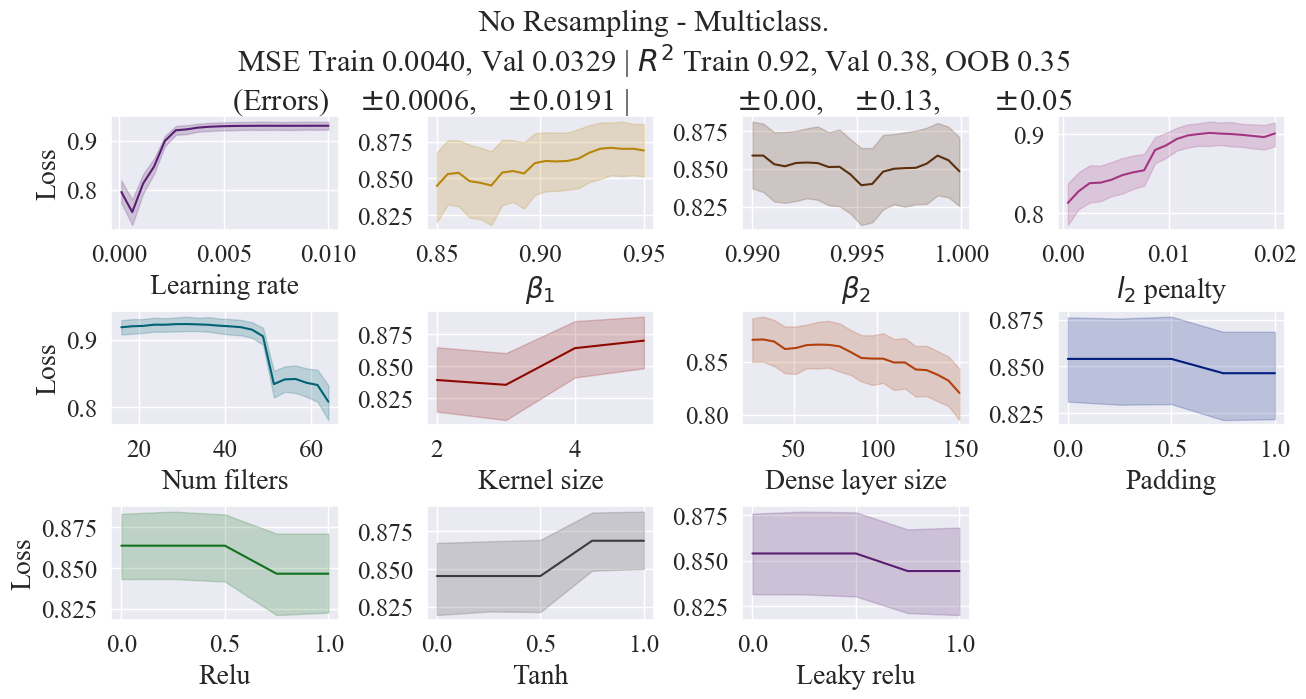

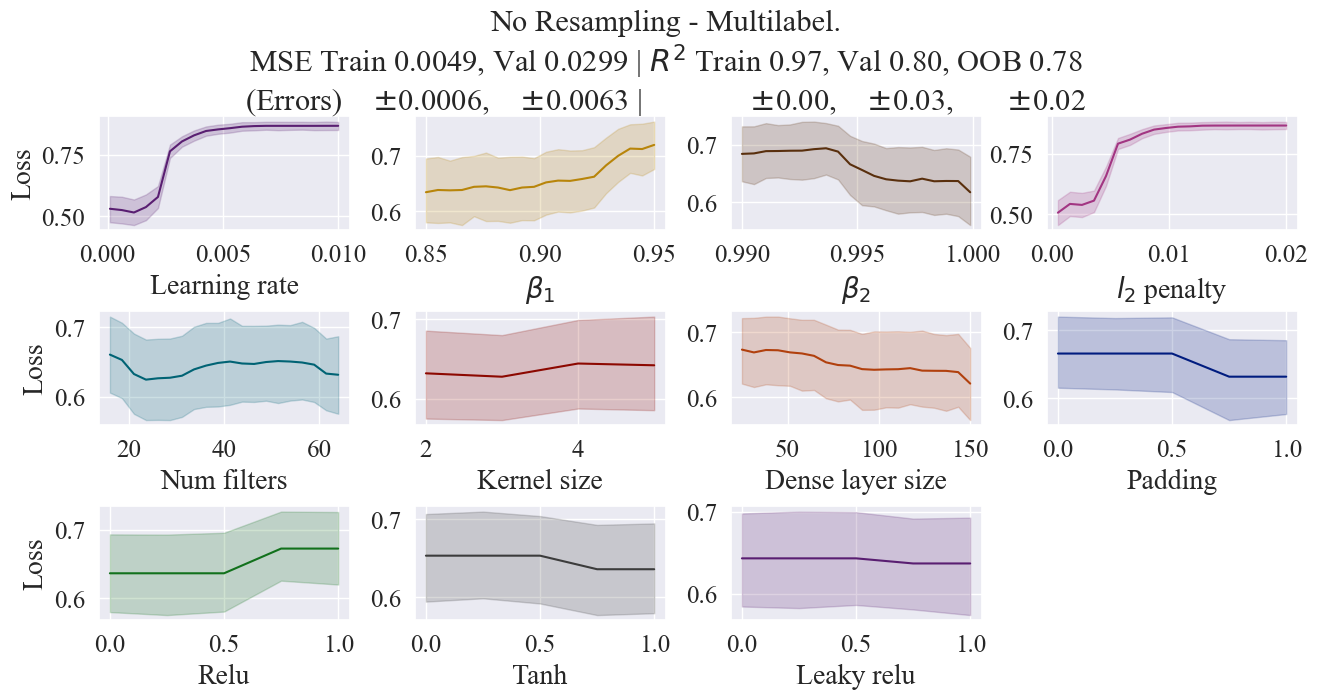

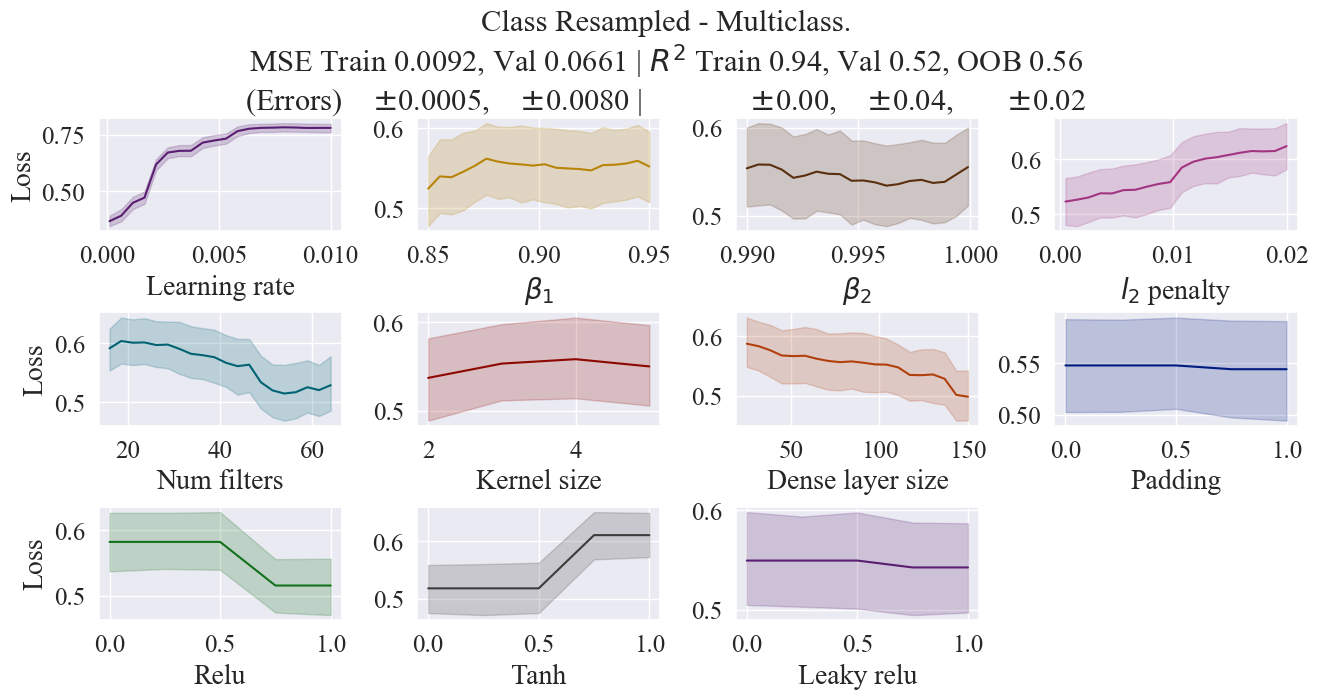

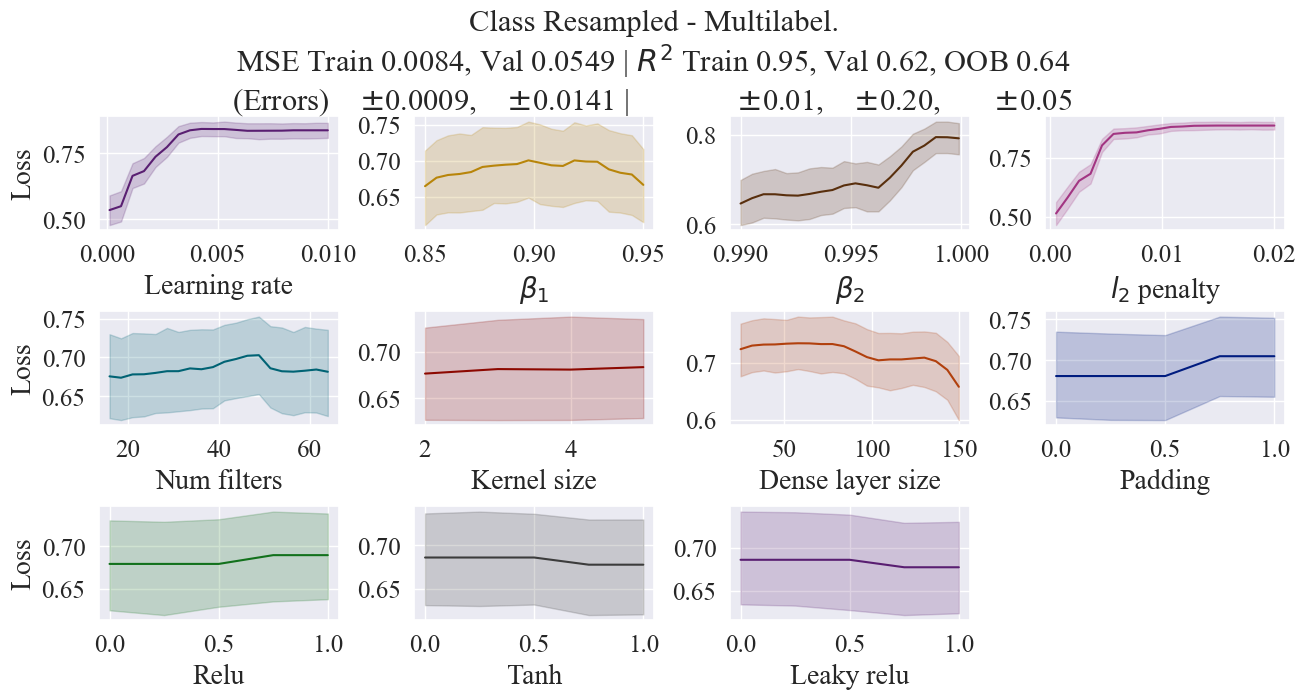

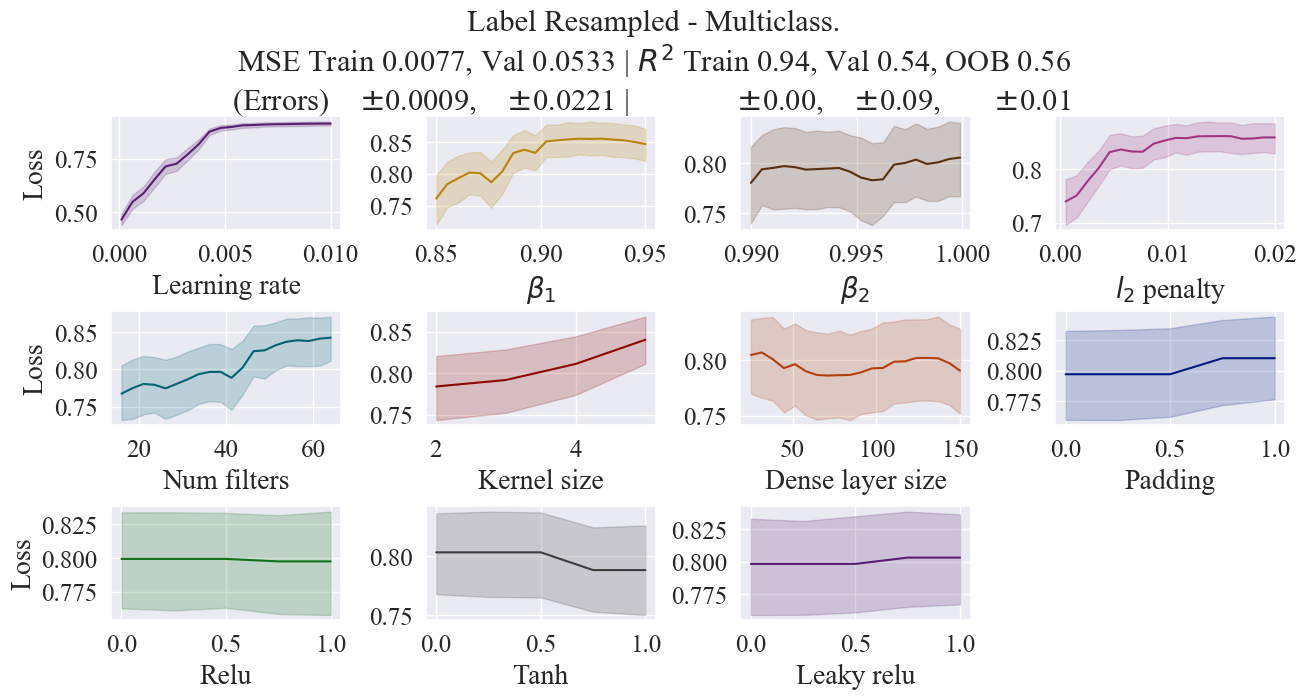

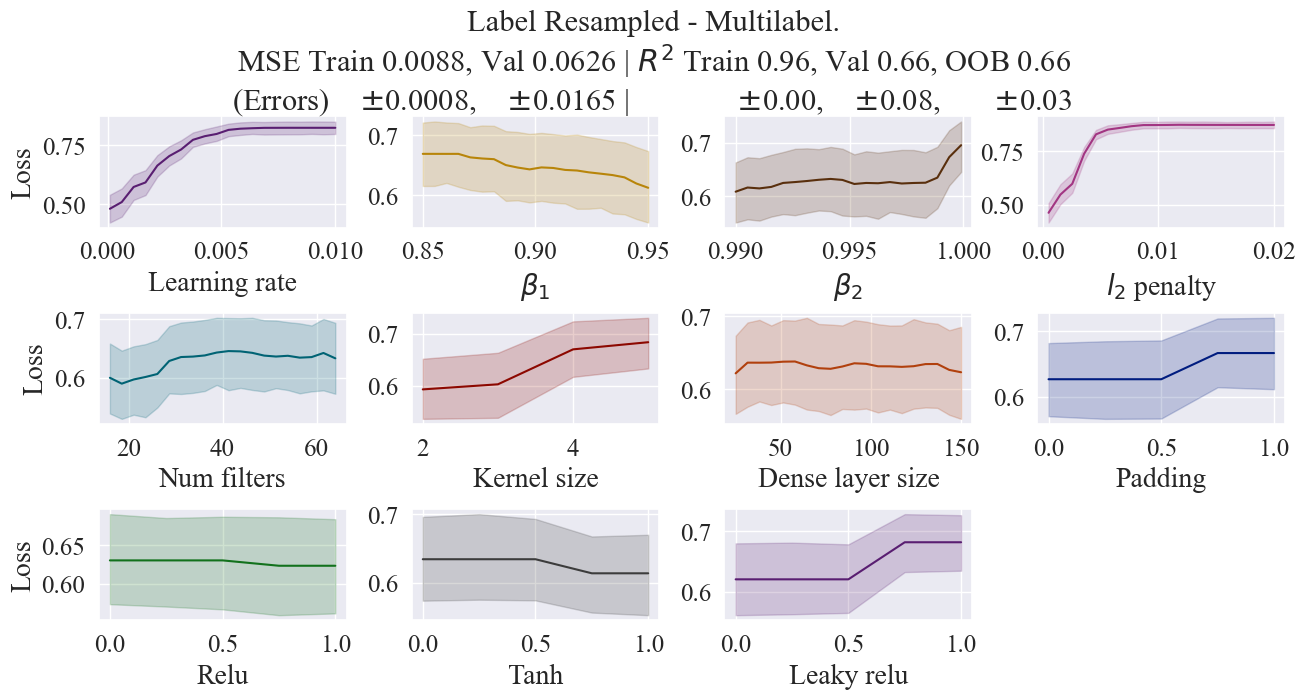

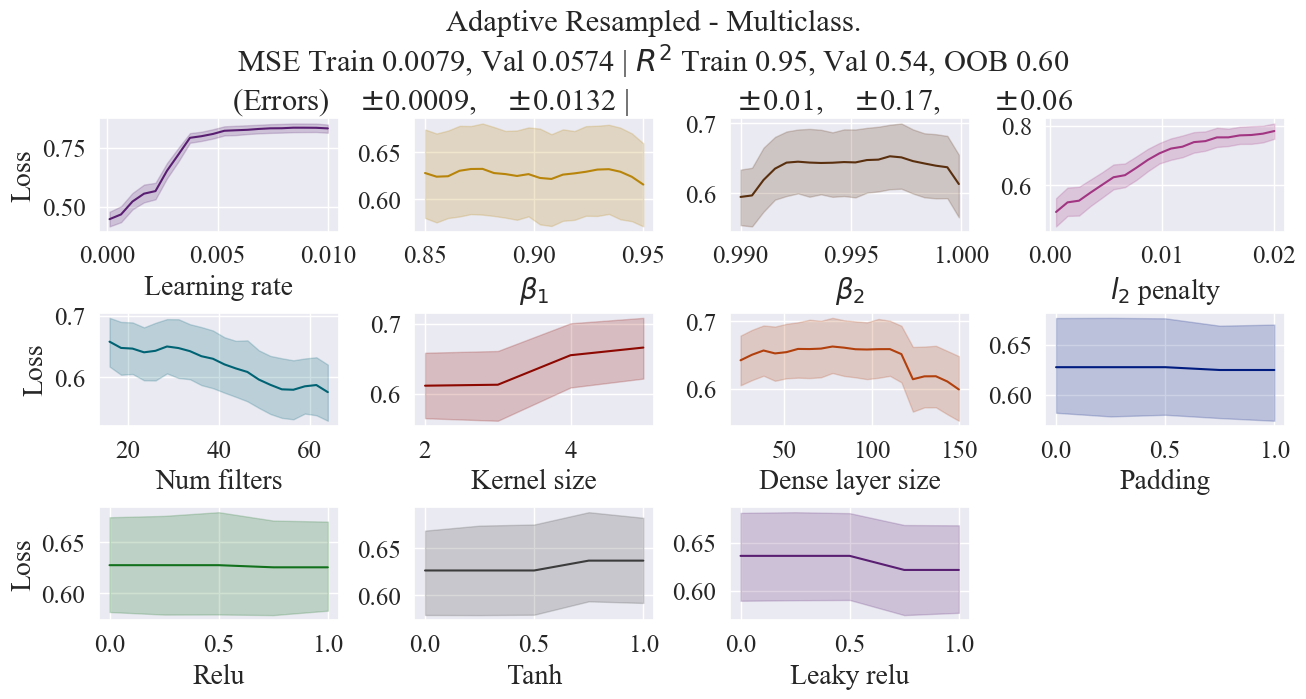

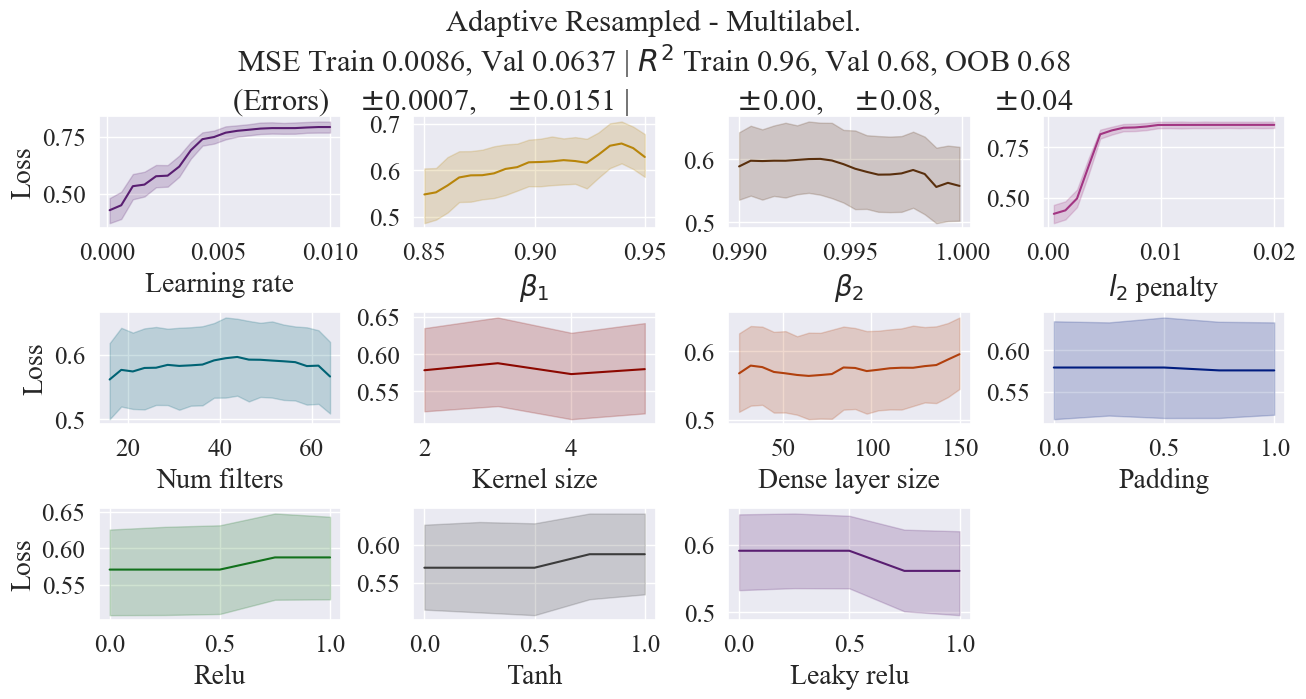

In [54]:

# fig, axes = plt.subplots(
#     2, 4, figsize=(18, 7), sharey='row', sharex='col'
# )
version = 'v1'

xcol = main_params + activ_names
xcol.remove(af)
ycol = "Normalised Loss"

records = {}

for r, resample in enumerate(resamplings):
    for m, model in enumerate(model_types):
        data = frace_config_normed[
                (frace_config_normed[TRAIN_COL] == resample) &
                (frace_config_normed[MODEL_COL] == model)
                ].sort_values(ycol).reset_index()
        data = pd.concat([data, pd.get_dummies(data[af])], axis=1).drop(columns=af)
        X = data[xcol].to_numpy().astype(float)
        Y = data[ycol].to_numpy().astype(float)
        
        rs = 10 + 2 ** r * 3 ** m * 5 ** r * 7 ** m
        kf = KFold(n_splits=5, shuffle=True, random_state=rs)
        sensitivities = {
            par: {
                'x': [],
                'y': []
            } for par in xcol
        }
        mse_t_cv = []
        mse_v_cv = []
        r2_t_cv = []
        r2_v_cv = []
        oob_r2_cv = []
        print(f"Analysing {model} under {resample} set.")
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            # print(f"Fold {i}:")
            trainX, trainY, valX, valY = X[train_index], Y[train_index], X[test_index], Y[test_index] 
            rf = RFR(
                n_estimators=100,
                criterion='squared_error',
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.0,
                max_features='sqrt',
                max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                bootstrap=True,
                oob_score=True,
                n_jobs=-1,
                random_state=rs,
                verbose=0,
                warm_start=False,
                ccp_alpha=0.0,
                max_samples=None,
                monotonic_cst=None
            )
            rf.fit(trainX, trainY)
            
            val_pred = rf.predict(valX)
            train_pred = rf.predict(trainX)
            mse_t = mean_squared_error(train_pred, trainY)
            mse_v = mean_squared_error(val_pred, valY)
            r2_t = rf.score(trainX, trainY)
            r2_v = rf.score(valX, valY)
            oob_r2 = rf.oob_score_
            mse_t_cv.append(mse_t)
            mse_v_cv.append(mse_v)
            r2_t_cv.append(r2_t)
            r2_v_cv.append(r2_v)
            oob_r2_cv.append(oob_r2)
            
            for p, par in enumerate(xcol):
                mn, mx = np.min(X[:, p]), np.max(X[:, p])
                
                N = valX.shape[0]
                val_range = get_sampled_parameters(par)
                augX = []
                for v in val_range:
                    aug = valX.copy()
                    aug[:, p] = v
                    augX.append(aug)
                augX = np.vstack(augX)
                preds = rf.predict(augX)
                sensitivities[par]['x'] = sensitivities[par]['x'] + list(augX[:, p])
                sensitivities[par]['y'] = sensitivities[par]['y'] + list(preds)
         
        prt_str = f"{resample} - {model}.\n" + \
                    f"MSE Train {np.mean(mse_t_cv):.4f}, Val {np.mean(mse_v_cv):.4f} | $R^2$ Train {np.mean(r2_t_cv):.2f}, Val {np.mean(r2_v_cv):.2f}, OOB {np.mean(oob_r2_cv):.2f}\n" + \
                    f"(Errors)    $\\pm${np.std(mse_t_cv):.4f},    $\\pm${np.std(mse_v_cv):.4f} |              $\\pm${np.std(r2_t_cv):.2f},    $\\pm${np.std(r2_v_cv):.2f},       $\\pm${np.std(oob_r2_cv):.2f} "
        print(prt_str)
        fig, axes = plt.subplots(3,4, figsize=(13,7))
        for i, par in enumerate(xcol):
            parf = ("$\\beta_1$" if par == 'Beta1'
                    else "$\\beta_2$" if par == 'Beta2'
                    else "$l_2$ penalty" if par == "L2 penalty"
                    else par)
            ax = axes[i // 4, i % 4]
            sns.lineplot(x=sensitivities[par]['x'], y=sensitivities[par]['y'], color=TPAL[i%10], ax=ax)
            ax.set_xlabel(parf, fontsize=TICK_SIZE)
            if i % 4 == 0:
                ax.set_ylabel("Loss", fontsize=TICK_SIZE)
            else:
                ax.set_ylabel("", fontsize=TICK_SIZE)
            ax.tick_params(axis='both', right=False, labelsize=TICK_SIZE-2)
        axes[-1,-1].axis('off')
        plt.suptitle(prt_str, fontsize=LBL_SIZE)
        plt.tight_layout(pad=0.35)     
        # plt.subplots_adjust(hspace=.7, wspace=0.15)
        plt.savefig(os.path.join(PLOTS, 'hyperparams', f"{abbreviations[resample]}_{abbreviations[model]}_sensitivity_{version}.pdf"), bbox_inches='tight')
        
        
        records[f"{abbreviations[resample]}-{abbreviations[model]}"] = {
            "sensitivities": sensitivities,
            "mse_t_cv": mse_t_cv,
            "mse_v_cv": mse_v_cv,
            "r2_t_cv": r2_t_cv,
            "r2_v_cv": r2_v_cv,
            "oob_r2_cv": oob_r2_cv
        }
        print("-"*100)
    #     break
    # break

In [435]:
r2_v

-3.4923064574613756

In [441]:
rs

1

In [406]:
TPAL

[(0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.0, 0.38823529411764707, 0.4549019607843137),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.0, 0.10980392156862745, 0.4980392156862745),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882)]

In [412]:
xcol

['Learning Rate',
 'Beta1',
 'Beta2',
 'L2 Penalty',
 'Num Filters',
 'Kernel Size',
 'Dense Layer Size',
 'Padding',
 'Leaky relu',
 'Relu',
 'Tanh']

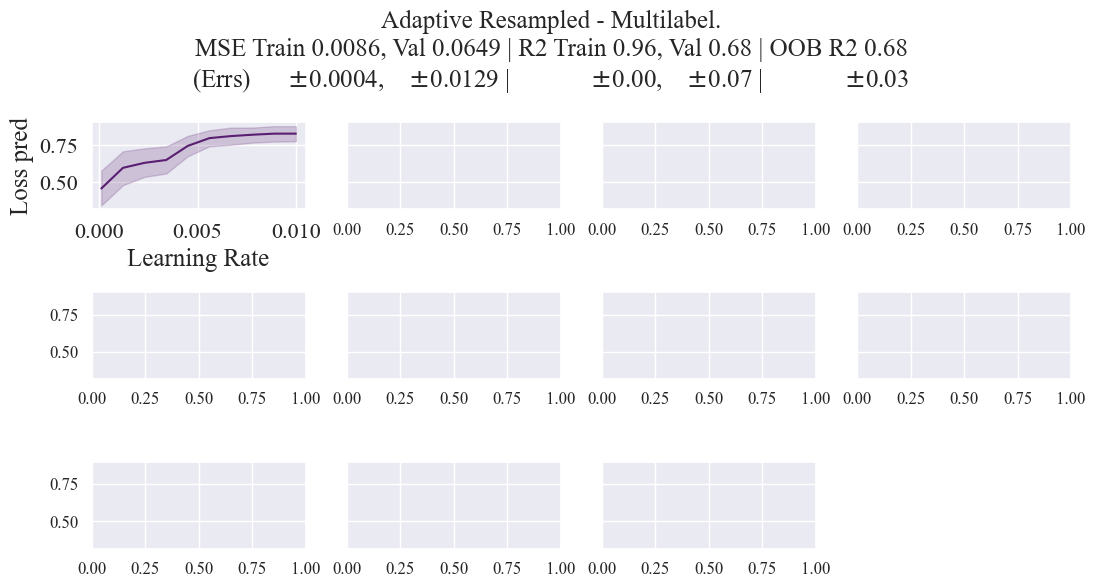

In [459]:

fig, axes = plt.subplots(3,4, figsize=(11,6), sharey=True)
for i, par in enumerate(xcol):
    ax = axes[i // 4, i % 4]
    mn, mx = np.min(X[:, i]), np.max(X[:, i])
    
    N = valX.shape[0]
    val_range = np.linspace(mn, mx, 10)
    augX = []
    for v in val_range:
        aug = valX.copy()
        aug[:, i] = v
        augX.append(aug)
    augX = np.vstack(augX)
    preds = rf.predict(augX)
    sns.lineplot(x=augX[:, i], y=preds, color=TPAL[i%10], ax=ax)
    ax.set_xlabel(par, fontsize=LBL_SIZE)
    ax.set_ylabel("Loss pred", fontsize=LBL_SIZE)
    ax.tick_params(axis='both', right=False, labelsize=TICK_SIZE)
    break
axes[-1,-1].axis('off')
# plt.subplots_adjust(hspace=0.25, wspace=0.09)
prt_str = f"{resample} - {model}.\n" + \
            f"MSE Train {np.mean(mse_t_cv):.4f}, Val {np.mean(mse_v_cv):.4f} | R2 Train {np.mean(r2_t_cv):.2f}, Val {np.mean(r2_v_cv):.2f} | OOB R2 {np.mean(oob_r2_cv):.2f}\n" + \
            f"(Errs)      $\\pm${np.std(mse_t_cv):.4f},    $\\pm${np.std(mse_v_cv):.4f} |             $\\pm${np.std(r2_t_cv):.2f},    $\\pm${np.std(r2_v_cv):.2f} |             $\\pm${np.std(oob_r2_cv):.2f} "

plt.suptitle(prt_str, fontsize=LBL_SIZE)
plt.tight_layout()

In [399]:
X[:, i].astype(int)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1])

### Correlations

In [563]:
frace_config_normed["Top 10"] = frace_config_normed.groupby([TRAIN_COL, MODEL_COL])[VAL_COL].apply(lambda g: np.argsort(np.argsort(g)) < 10).reset_index()[VAL_COL]
frace_config_normed.head()

ID  Configuration ID  Learning rate     Beta1     Beta2  L2 penalty  \
0  AR_MC_0                 0       0.002799  0.872994  0.995875    0.010593   
1  AR_MC_1                 1       0.006618  0.903780  0.991821    0.005815   
2  AR_MC_2                 2       0.008847  0.886139  0.999438    0.018049   
3  AR_MC_3                 3       0.000698  0.943731  0.992976    0.003482   
4  AR_MC_4                 4       0.002374  0.888583  0.990607    0.002717   

   Num filters  Kernel size  Dense layer size Activation function  Padding  \
0           31            2               130          Leaky relu     True   
1           48            5                27                Relu    False   
2           62            4               111                Tanh    False   
3           18            3                74                Tanh     True   
4           24            3                94                Tanh    False   

  Resampling Scenario       Model  Mean Validation Loss  Normalised Loss  \
0  Adaptive Resampled  Multiclass              3.954759         0.994149   
1  Adaptive Resampled  Multiclass              2.583850         0.649529   
2  Adaptive Resampled  Multiclass              3.954846         0.994171   
3  Adaptive Resampled  Multiclass              0.328711         0.082631   
4  Adaptive Resampled  Multiclass              0.242760         0.061025   

   Top 10  
0   False  
1   False  
2   False  
3   False  
4    True

In [564]:
n_param = [lr, b1, b2, nf, ks, ds, pa, l2]

frace_numeric = frace_config_normed[
    n_param
]

frace_bests_numeric = frace_config_normed[
    frace_config_normed['Top 10']
    ][
    n_param
]
display(frace_numeric.head())
display(frace_numeric.info())
display(frace_bests_numeric.head())
display(frace_bests_numeric.info())

Learning rate     Beta1     Beta2  Num filters  Kernel size  \
0       0.002799  0.872994  0.995875           31            2   
1       0.006618  0.903780  0.991821           48            5   
2       0.008847  0.886139  0.999438           62            4   
3       0.000698  0.943731  0.992976           18            3   
4       0.002374  0.888583  0.990607           24            3   

   Dense layer size  Padding  L2 penalty  
0               130     True    0.010593  
1                27    False    0.005815  
2               111    False    0.018049  
3                74     True    0.003482  
4                94    False    0.002717

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Learning rate     768 non-null    float64
 1   Beta1             768 non-null    float64
 2   Beta2             768 non-null    float64
 3   Num filters       768 non-null    int64  
 4   Kernel size       768 non-null    int64  
 5   Dense layer size  768 non-null    int64  
 6   Padding           768 non-null    bool   
 7   L2 penalty        768 non-null    float64
dtypes: bool(1), float64(4), int64(3)
memory usage: 42.9 KB


None

Learning rate     Beta1     Beta2  Num filters  Kernel size  \
4        0.002374  0.888583  0.990607           24            3   
12       0.000804  0.857173  0.998829           52            3   
25       0.000489  0.884717  0.999900           53            2   
28       0.000100  0.907254  0.997772           55            5   
38       0.003120  0.850000  0.999900           64            2   

    Dense layer size  Padding  L2 penalty  
4                 94    False    0.002717  
12               123     True    0.007424  
25               150    False    0.002628  
28               150     True    0.000500  
38                25    False    0.000500

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 4 to 766
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Learning rate     80 non-null     float64
 1   Beta1             80 non-null     float64
 2   Beta2             80 non-null     float64
 3   Num filters       80 non-null     int64  
 4   Kernel size       80 non-null     int64  
 5   Dense layer size  80 non-null     int64  
 6   Padding           80 non-null     bool   
 7   L2 penalty        80 non-null     float64
dtypes: bool(1), float64(4), int64(3)
memory usage: 5.1 KB


None

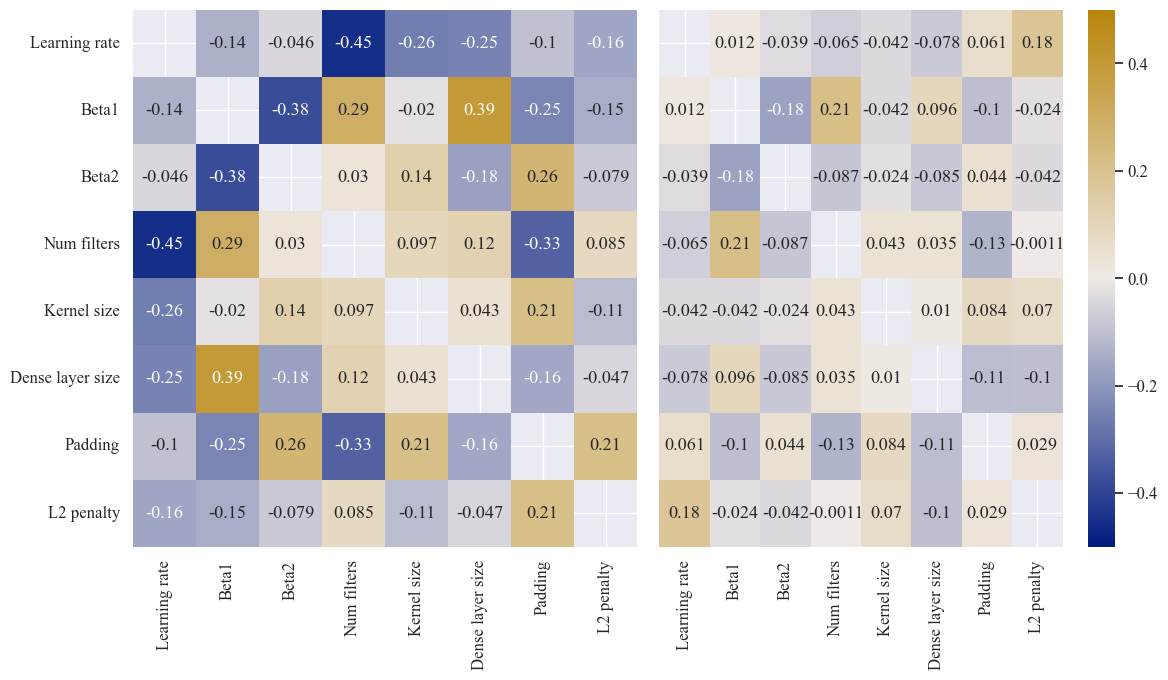

In [565]:
base_corrs = np.corrcoef(frace_numeric.T.to_numpy().astype(float))
bests_corrs = np.corrcoef(frace_bests_numeric.T.to_numpy().astype(float))

base_corrs = np.where(base_corrs >= 0.99, np.nan, base_corrs)
bests_corrs = np.where(bests_corrs >= 0.99, np.nan, bests_corrs)

fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True)
sns.heatmap(base_corrs, ax=axes[1], cmap=CTS_PAL, vmin=-0.5, vmax=0.5, annot=True)
sns.heatmap(bests_corrs, ax=axes[0], cmap=CTS_PAL, vmin=-0.5, vmax=0.5, cbar=False, annot=True)

ts = [t + 0.5 for t in range(8)]
axes[0].set_yticks(ts, n_param)
axes[0].set_xticks(ts, n_param)
axes[1].set_xticks(ts, n_param)
axes[0].tick_params(axis='y', labelrotation=0)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
plt.tight_layout()